## ICU Length  of stay using LightGBM Model & Tranformer Models

In [2]:
import math
#import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
#import tensorflow_addons as tfa
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')


#from tensorflow.keras.callbacks import EarlyStopping

#from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
#from tabtransformertf.utils.preprocessing import df_to_dataset

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')
## reading careplans csv
#/content/gdrive/MyDrive/Colab Notebooks/covid/100k_synthea_covid19_csv/allergies.csv

In [4]:
devices = pd.read_csv("100k_synthea_covid19_csv/devices.csv")
devices_test = pd.read_csv("10k_synthea_covid19_csv/devices.csv")

imaging_studies = pd.read_csv("100k_synthea_covid19_csv/imaging_studies.csv")
imaging_studies_test = pd.read_csv("10k_synthea_covid19_csv/imaging_studies.csv")

immunizations = pd.read_csv("100k_synthea_covid19_csv/immunizations.csv")
immunizations_test = pd.read_csv("10k_synthea_covid19_csv/immunizations.csv")

medications = pd.read_csv("100k_synthea_covid19_csv/medications.csv")
medications_test = pd.read_csv("10k_synthea_covid19_csv/medications.csv")

providers = pd.read_csv("100k_synthea_covid19_csv/providers.csv")
providers_test = pd.read_csv("10k_synthea_covid19_csv/providers.csv")

allergies = pd.read_csv("100k_synthea_covid19_csv/allergies.csv")
allergies_test = pd.read_csv("10k_synthea_covid19_csv/allergies.csv")

conditions = pd.read_csv("100k_synthea_covid19_csv/conditions.csv")
conditions_test = pd.read_csv("10k_synthea_covid19_csv/conditions.csv")

patients = pd.read_csv("100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("10k_synthea_covid19_csv/patients.csv")

encounters = pd.read_csv("100k_synthea_covid19_csv/encounters.csv")
encounters_test = pd.read_csv("10k_synthea_covid19_csv/encounters.csv")


In [5]:
def patients_reader(data, goal):
    data.DEATHDATE.fillna("2021-01-01", inplace = True) 
    data.DEATHDATE = pd.to_datetime(data["DEATHDATE"])
    data.BIRTHDATE =  pd.to_datetime(data["BIRTHDATE"])
    data["age"] =data.DEATHDATE- data.BIRTHDATE
    data['age'] = data.age.astype('timedelta64[Y]').astype('int')
    data["healthcare_coverage_ratio"] = data.HEALTHCARE_COVERAGE / data.HEALTHCARE_EXPENSES
    data["dataset"] = goal
    data.MARITAL.fillna("S", inplace = True)
    data.drop_duplicates(inplace = True) 
    data = data[['Id', "age", "MARITAL", "RACE", "ETHNICITY", "GENDER", "CITY", "COUNTY", "healthcare_coverage_ratio"]]
    #data = data.rename(columns = {"Id": "patient"})
    return data

patients = pd.read_csv("100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("10k_synthea_covid19_csv/patients.csv")
patients = patients_reader(patients, "train")
patients_test = patients_reader(patients_test, "test")

In [6]:
def icu_preparation(encounter, condition, patient):
    covid_patient_ids = condition[condition.CODE == 840539006].PATIENT.unique()
    covid_conditions = condition[condition.CODE == 840539006]
    cp = covid_conditions.merge(patient, how='left', left_on='PATIENT', right_on='Id')
    icu_ids = encounter[encounter.CODE == 305351004].PATIENT
    cp['icu_admit'] = cp.Id.isin(icu_ids)
    icu_only = cp[cp.icu_admit == True]
    icu_only.START = pd.to_datetime(icu_only.START)
    icu_only.STOP = pd.to_datetime(icu_only.STOP)
    icu_only["duration"] = (icu_only.STOP - icu_only.START).dt.days
    icu_only = icu_only.loc[icu_only.STOP.notnull()].reset_index(drop = True)
    #icu_only["age"] = pd.to_datetime(icu_only["DEATHDATE"]) - pd.to_datetime(icu_only["BIRTHDATE"])
    #icu_only["healthcare_coverage_ratio"] = icu_only.HEALTHCARE_COVERAGE / icu_only.HEALTHCARE_EXPENSES
    needed_columns = ["START", "STOP", "PATIENT", "MARITAL", "RACE", "ETHNICITY", "GENDER", "CITY", "COUNTY", "healthcare_coverage_ratio" ,
                      "duration"]

    df = icu_only[needed_columns]
    return df

In [7]:
df = icu_preparation(encounters, conditions, patients)
test = icu_preparation(encounters_test, conditions_test, patients_test)

In [8]:
df.head()

,START,STOP,PATIENT,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,healthcare_coverage_ratio,duration
0,2020-03-10,2020-03-27,a2a8e809-cc34-4f8e-93b8-74e4a87f35ef,M,white,nonhispanic,M,Somerville,Middlesex County,0.005663,17.0
1,2020-03-11,2020-03-25,30ce94e8-8c50-4588-97f6-b8aa1df0e9d2,S,asian,nonhispanic,M,Lunenburg,Worcester County,0.004333,14.0
2,2020-03-04,2020-03-23,ca17602b-8df5-4600-aa0f-172e77a4a23a,S,white,nonhispanic,M,Eastham,Barnstable County,0.000000,19.0
3,2020-03-01,2020-03-19,f83adf12-c7d3-46f6-af93-605473232d42,M,white,nonhispanic,M,Eastham,Barnstable County,0.003991,18.0
4,2020-03-09,2020-03-27,e984b28a-81f1-41ab-8c3a-6dd3a965d2be,S,white,nonhispanic,F,Brewster,Barnstable County,0.005461,18.0


In [9]:
df = df.rename(columns = {"START" : "icu_start", "STOP" : "icu_stop"})
test = test.rename(columns = {"START" : "icu_start", "STOP" : "icu_stop"})

In [10]:
def patients_reader(data, goal):
    data.DEATHDATE.fillna("2021-01-01", inplace = True) 
    data.DEATHDATE = pd.to_datetime(data["DEATHDATE"])
    data.BIRTHDATE =  pd.to_datetime(data["BIRTHDATE"])
    data["age"] =data.DEATHDATE- data.BIRTHDATE
    data['age'] = data.age.astype('timedelta64[Y]').astype('int')
    data["healthcare_coverage_ratio"] = data.HEALTHCARE_COVERAGE / data.HEALTHCARE_EXPENSES
    data["dataset"] = goal
    data.MARITAL.fillna("S", inplace = True)
    data.drop_duplicates(inplace = True) 
    data = data[['Id', "age", "MARITAL", "RACE", "ETHNICITY", "GENDER", "CITY", "COUNTY", "healthcare_coverage_ratio"]]
    #data = data.rename(columns = {"Id": "patient"})
    return data

In [11]:
patients = pd.read_csv("100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("10k_synthea_covid19_csv/patients.csv")
patients = patients_reader(patients, "train")
patients_test = patients_reader(patients_test, "test")

In [12]:
def mode_finder(x): 
    m = pd.Series.mode(x); 
    return m.values[0] if not m.empty else np.nan

In [13]:
# Careplan

careplan_df = pd.read_csv("100k_synthea_covid19_csv/careplans.csv")
careplan_df_test = pd.read_csv("10k_synthea_covid19_csv/careplans.csv")

careplan_df.DESCRIPTION = careplan_df.DESCRIPTION.apply(lambda x : x.replace("(", ""))
careplan_df.DESCRIPTION = careplan_df.DESCRIPTION.apply(lambda x : x.replace(")", ""))

careplan_df_test.DESCRIPTION = careplan_df_test.DESCRIPTION.apply(lambda x : x.replace("(", ""))
careplan_df_test.DESCRIPTION = careplan_df_test.DESCRIPTION.apply(lambda x : x.replace(")", ""))

def careplan_reader(data, goal):
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION", "REASONDESCRIPTION"]]
    data.columns = ["patient", "careplan_start", "careplan_end", "careplan_desc", "careplan_reason"]
    if goal == "train":
        for i in data.careplan_desc.value_counts().index[:10]:
            name = i
            data.loc[data.careplan_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
      for i in careplan_df.careplan_desc.value_counts().index[:10]:
            name =  i
            data.loc[data.careplan_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")

            data[name].fillna(0, inplace = True)
    data["patient's most seen careplan"] = data.groupby("patient")["careplan_desc"].transform(mode_finder)
    data = data.loc[data.careplan_reason == "COVID-19"].reset_index(drop = True)
        
    
    data["dataset"] = goal
    
    data.drop_duplicates(inplace = True) 
    return data

careplan_df = careplan_reader(careplan_df, "train")
careplan_df_test = careplan_reader(careplan_df_test, "test")

In [14]:
df = df.rename(columns = {"PATIENT" : "patient"})
test = test.rename(columns = {"PATIENT" : "patient"})

In [15]:

careplan_df = pd.merge(careplan_df, df,  on='patient', how = "right")

careplan_df_test = pd.merge(careplan_df_test, test,  on='patient', how = "right")

In [16]:
#Conditions

conditions_df = pd.read_csv("100k_synthea_covid19_csv/conditions.csv")
conditions_df_test = pd.read_csv("10k_synthea_covid19_csv/conditions.csv")

conditions_df['DESCRIPTION'] = conditions_df['DESCRIPTION'].str.replace("(","")
conditions_df['DESCRIPTION'] = conditions_df['DESCRIPTION'].str.replace(")","")
                                                                           
conditions_df_test['DESCRIPTION'] = conditions_df_test['DESCRIPTION'].str.replace("(","")
conditions_df_test['DESCRIPTION'] = conditions_df_test['DESCRIPTION'].str.replace(")","")
features = conditions_df.DESCRIPTION.value_counts().index[:40]

def condition_reader(data, train = True):
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION"]]
    data.columns = ["patient", "condition_start", "condition_stop", "condition_desc"]
    data.condition_start = pd.to_datetime(data.condition_start)
    data.condition_stop = pd.to_datetime(data.condition_stop)
    if train == True:
        for i in features:
            name = "patient's_condition_of_" + i
            data.loc[data.condition_desc.astype(str).str.contains(i[:10]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
        for i in features:
            name = "patient's_condition_of_" + i
            data.loc[data.condition_desc.astype(str).str.contains(i[:10]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
        
    data["patient's most seen condition"] = data.groupby("patient")["condition_desc"].transform(mode_finder)
    data["condition_duration"] = (data.condition_stop - data.condition_start).dt.days
    data["patient_condition_count"] = data.groupby("patient")["condition_desc"].transform("count") # how many conditions?
    data["patient_condition_unique"] = data.groupby("patient")["condition_desc"].transform("nunique") # how many unique conditions?
    data["patient_condition_days_avg"] = data.groupby("patient")["condition_duration"].transform("mean") # avg. day under conditions?
    data["patient_condition_days_sum"] = data.groupby("patient")["condition_duration"].transform("sum")
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data

conditions_df = condition_reader(conditions_df)
conditions_df_test = condition_reader(conditions_df_test)

In [17]:
needed_columns = []
for i in conditions_df.columns:
    if "patient" in i:
        needed_columns.append(i)
        
        
conditions_df = conditions_df[needed_columns].drop_duplicates()
conditions_df_test = conditions_df_test[needed_columns].drop_duplicates()

In [18]:
conditions_df.head()

,patient,patient's_condition_of_Suspected COVID-19,patient's_condition_of_COVID-19,patient's_condition_of_Fever finding,patient's_condition_of_Cough finding,patient's_condition_of_Body mass index 30+ - obesity finding,patient's_condition_of_Loss of taste finding,patient's_condition_of_Prediabetes,patient's_condition_of_Anemia disorder,patient's_condition_of_Fatigue finding,...,patient's_condition_of_Stroke,patient's_condition_of_Osteoarthritis of knee,patient's_condition_of_Osteoporosis disorder,patient's_condition_of_Chronic intractable migraine without aura,patient's_condition_of_History of appendectomy,patient's most seen condition,patient_condition_count,patient_condition_unique,patient_condition_days_avg,patient_condition_days_sum
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Otitis media,5,4,63.400000,317.0
5,9bcf6ed5-d808-44af-98a0-7d78a29ede72,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,COVID-19,8,8,23.000000,184.0
13,5163c501-353c-4a82-b863-a3f1df2d6cf1,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Acute bronchitis disorder,6,6,17.666667,106.0
19,cc3c806f-4a09-4a89-a990-4286450956be,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,COVID-19,4,4,14.250000,57.0
23,bd1c4ffc-7f1d-4590-adbb-1d6533fb623e,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Acute pulmonary embolism disorder,9,9,7.125000,57.0


In [19]:
medications_df = pd.read_csv("100k_synthea_covid19_csv/medications.csv")
medications_df_test = pd.read_csv("10k_synthea_covid19_csv/medications.csv")
features = medications_df.DESCRIPTION.value_counts().index[:30]

def medication_reader(data, train = True):
    
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION", "TOTALCOST", "REASONDESCRIPTION"]]
    data.columns = ["patient", "med_start", "med_stop", "med_desc", "med_total_cost", "med_reason"]
    data.med_start = pd.to_datetime(data.med_start)
    data.med_stop = pd.to_datetime(data.med_stop)
    data.med_desc = data.med_desc.replace([")", "("], "")
    if train == True:
        for i in features:
            name = "patient's_medication_of_" + i
            data.loc[data.med_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
        for i in features:
            name = "patient's_medication_of_" + i
            data.loc[data.med_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
        
    data["patient's most used medication"] = data.groupby("patient")["med_desc"].transform(mode_finder)
    data["patient's most usage reason"] = data.groupby("patient")["med_reason"].transform(mode_finder)
    data["med_duration"] = (data.med_stop - data.med_start).dt.days + 1
    data["total_med_duration_of_patient"] = data.groupby("patient")["med_duration"].transform("sum")
    data["total_med_cost_of_patient"] = data.groupby("patient")["med_total_cost"].transform("sum")
    data["total_med_count_of_patient"] = data.groupby("patient")["med_desc"].transform("count")
    data["total_unique_med_of_patient"] = data.groupby("patient")["med_desc"].transform("nunique")
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data
        

medications_df = medication_reader(medications_df)
medications_df_test = medication_reader(medications_df_test, train = "False")

In [20]:
needed_columns = []
for i in medications_df.columns:
    if "patient" in i:
        needed_columns.append(i)
medications_df = medications_df[needed_columns].drop_duplicates()
medications_df_test = medications_df_test[needed_columns].drop_duplicates()

In [21]:
#Observations

observations_df = pd.read_csv("100k_synthea_covid19_csv/observations.csv").sample(frac = 0.001)
observations_df_test = pd.read_csv("10k_synthea_covid19_csv/observations.csv").sample(frac = 0.001)
observations_df_test.DESCRIPTION = observations_df_test.DESCRIPTION.replace([")", "/", "[", "/", "]",  "#","("], "")
observations_df.DESCRIPTION = observations_df.DESCRIPTION.replace([")", "/", "[", "/", "]",  "#","("], "")
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.strip()     
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(' ', '_')         
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(r"[^a-zA-Z\d\_]+", "")    
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(r"[^a-zA-Z\d\_]+", "")
features = observations_df.DESCRIPTION.value_counts().index[:30]

def observation_reader(data,  train = True):
    data = data[["DATE", "PATIENT", "DESCRIPTION", "VALUE"]]
    data.columns = ["obs_date", "patient", "obs_desc", "obs_value"]
    data.obs_value.fillna(0, inplace = True)
    data.obs_desc = data.obs_desc.replace([")", "("], "")

    if train == True:
        for i in features:
            name = "patient's_observation_of_" + i
            data.loc[data.obs_desc.astype(str).str.contains(i[:15]), name] = data.loc[data.obs_desc.astype(str).str.contains(i[:15])].groupby("patient")["obs_value"].transform(mode_finder)
            #data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
            
    else:
        for i in features:
            name = "patient's_observation_of_" + i
            data.loc[data.obs_desc.astype(str).str.contains(i[:15]), name] = data.loc[data.obs_desc.astype(str).str.contains(i[:15])].groupby("patient")["obs_value"].transform(mode_finder)
            #data[name] = data.groupby("patient")[name].transform("max")

            data[name].fillna(0, inplace = True)
    
    data["patient's most seen observation"] = data.groupby("patient")["obs_desc"].transform(mode_finder)

    data["patient_obs_count"] = data.groupby("patient")["obs_desc"].transform("count")
    data["patient_obs_count_unique"] = data.groupby("patient")["obs_desc"].transform("nunique")   
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data



In [22]:
observations_df = observation_reader(observations_df)
observations_df_test = observation_reader(observations_df_test, train =  "False")

In [23]:
needed_columns = []
for i in observations_df.columns:
    if "patient" in i:
        needed_columns.append(i)
observations_df = observations_df[needed_columns].drop_duplicates()
observations_df_test = observations_df_test[needed_columns].drop_duplicates()

In [24]:
observations_df.head()

,patient,patient's_observation_of_Diastolic_Blood_Pressure,patient's_observation_of_Systolic_Blood_Pressure,patient's_observation_of_Heart_rate,patient's_observation_of_Respiratory_rate,patient's_observation_of_Body_Weight,patient's_observation_of_Oxygen_saturation_in_Arterial_blood,patient's_observation_of_Body_temperature,patient's_observation_of_Bilirubintotal_Massvolume_in_Serum_or_Plasma,patient's_observation_of_Leukocytes_volume_in_Blood_by_Automated_count,...,patient's_observation_of_Creatinine_Massvolume_in_Serum_or_Plasma,patient's_observation_of_Albumin_Massvolume_in_Serum_or_Plasma,patient's_observation_of_Neutrophils100_leukocytes_in_Blood_by_Automated_count,patient's_observation_of_Sodium_Molesvolume_in_Serum_or_Plasma,patient's_observation_of_Eosinophils_volume_in_Blood_by_Automated_count,patient's_observation_of_Calcium_Massvolume_in_Serum_or_Plasma,patient's_observation_of_Neutrophils_volume_in_Blood_by_Automated_count,patient's most seen observation,patient_obs_count,patient_obs_count_unique
12997088,51b24042-9e55-4ab8-afeb-369f180e57a5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.5,0,0,Eosinophils_volume_in_Blood_by_Automated_count,2,2
15440462,bc24dd29-dcdf-4e0e-9d46-1d93259ec516,0,0,0,15.0,0,0,0,0,0,...,0,0,0,0,0,0,0,Respiratory_rate,1,1
15473400,4dfd0662-3c7e-43e9-82a9-173caf0414e0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Pain_severity__010_verbal_numeric_rating_Score...,1,1
12726117,ec99b7db-c157-4395-84d8-6e915e842418,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Globulin_Massvolume_in_Serum_by_calculation,1,1
10721851,bd934274-4b8e-4aa8-9330-0c80f6f5ca7b,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3.8,Basophils_volume_in_Blood_by_Automated_count,2,2


In [25]:
#Allergies
features = allergies.DESCRIPTION.value_counts().index[:10]

def allergies_reader(data, feature = "DESCRIPTION", train = True):
      data["unique_allergies_per_patient"] = data.groupby(["PATIENT"])[feature].transform("nunique")
      data = data.rename(columns = {"PATIENT" : "patient"})
      if train == True:
            for i in features:
                  name = "patient's_alergy_of_" + i
                  data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
                  data[name] = data.groupby("patient")[name].transform("max")

                  data[name].fillna(0, inplace = True)
      else:
        for i in features:
                  name = "patient's_alergy_of_" + i
                  data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
                  data[name] = data.groupby("patient")[name].transform("max")

                  data[name].fillna(0, inplace = True)
      data["patient's most seen allergy"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)

      return data
allergies_df = allergies_reader(allergies, "DESCRIPTION")
allergies_test_df = allergies_reader(allergies_test, "DESCRIPTION")

In [26]:
allergies_df.head()

,START,STOP,patient,ENCOUNTER,CODE,DESCRIPTION,unique_allergies_per_patient,patient's_alergy_of_Allergy to mould,patient's_alergy_of_Dander (animal) allergy,patient's_alergy_of_Allergy to grass pollen,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy
0,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,424213003,Allergy to bee venom,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
1,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,418689008,Allergy to grass pollen,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
2,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,419263009,Allergy to tree pollen,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
3,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,417532002,Allergy to fish,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
4,2002-02-24,NaN,29581d13-2687-402f-9c4c-06141a319e61,1d1e8b9d-00c5-47dc-a635-16769715d7cc,91934008,Allergy to nut,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Allergy to nut


In [27]:
#Imaging Studies

def imaging_studies_reader(df):
        df = df[["PATIENT", "BODYSITE_DESCRIPTION", "MODALITY_DESCRIPTION"]]

        for i in df.MODALITY_DESCRIPTION.unique():
            df.loc[df.MODALITY_DESCRIPTION == i, i] = 1
        df.fillna(0, inplace = True)
        for i in ['Digital Radiography', 'Ultrasound', 'Computed Radiography',
            'Computed Tomography']:
            name = "patient's " + i + "count"
            df[name] = df.groupby("PATIENT")[i].transform("sum")
        df = df.drop(['Digital Radiography', 'Ultrasound', 'Computed Radiography',
            'Computed Tomography', "MODALITY_DESCRIPTION"], 1)
        df["patient's_different_bodysite_imaging_studies"] = df.groupby("PATIENT")["BODYSITE_DESCRIPTION"].transform("nunique")
        df.drop(["BODYSITE_DESCRIPTION"], 1, inplace = True)
        df = df.rename(columns = {"PATIENT" : "patient"})
        return df
imaging_studies_df = imaging_studies_reader(imaging_studies)
imaging_studies_test_df = imaging_studies_reader(imaging_studies_test)

In [28]:
#Immunizations
def immunizations_reader(df):
    df["unique_immunizations"] = df.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    df = df[["PATIENT", "unique_immunizations"]]  
    df = df.rename(columns = {"PATIENT" : "patient"})
    return df

In [29]:
immunizations_df = immunizations_reader(immunizations)
immunizations_test_df = immunizations_reader(immunizations_test)

In [30]:
encounters = pd.read_csv("100k_synthea_covid19_csv/encounters.csv")
encounters_test = pd.read_csv("10k_synthea_covid19_csv/encounters.csv")


In [31]:
features = encounters.DESCRIPTION.value_counts().index[:15]


def encounters_reader(data, train = True):
    data = data[["PATIENT", "ENCOUNTERCLASS", "DESCRIPTION"]]
    data["unique_encounters_per_patient"] = data.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    data = data.rename(columns = {"PATIENT": "patient"})
    if train == True:
      for i in features:
          name = i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")
          data[name].fillna(0, inplace = True)
      for i in data.ENCOUNTERCLASS.unique():
          name = i
          data.loc[data.ENCOUNTERCLASS.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
    else:
      for i in features:
          name =  i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
      for i in devices.ENCOUNTERCLASS.unique():
          name = i
          data.loc[data.ENCOUNTERCLASS.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
    
    data["patient's most seen encounter"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)

    return data



encounters_df = encounters_reader(encounters)
encounters_df_test = encounters_reader(encounters_test)

In [32]:
encounters_df.head()

,patient,ENCOUNTERCLASS,DESCRIPTION,unique_encounters_per_patient,General examination of patient (procedure),Encounter for check up (procedure),Follow-up encounter,Encounter for symptom,Encounter for problem,Well child visit (procedure),...,Consultation for treatment,Outpatient procedure,Encounter for 'check-up',outpatient,wellness,ambulatory,emergency,inpatient,urgentcare,patient's most seen encounter
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,outpatient,Encounter for symptom,3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
1,1ff7f10f-a204-4bb1-aa72-dd763fa99482,wellness,Well child visit (procedure),3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
2,1ff7f10f-a204-4bb1-aa72-dd763fa99482,outpatient,Encounter for symptom,3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
3,1ff7f10f-a204-4bb1-aa72-dd763fa99482,wellness,Well child visit (procedure),3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
4,1ff7f10f-a204-4bb1-aa72-dd763fa99482,ambulatory,Encounter for symptom (procedure),3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom


In [33]:
#Providers
def provider_reader(df):
    df = df[["Id", "CITY"]]
    df["doctor_count_per_city"] = df.groupby("CITY")["Id"].transform("nunique")
    df = df[["CITY", "doctor_count_per_city"]]
    return df

In [34]:
providers_df = provider_reader(providers)
providers_df_test = provider_reader(providers_test)

In [35]:
#Devices
def devices_reader(data, train = True):
    data = data[["PATIENT", "DESCRIPTION"]]
    data["used_unique_device_per_patient"] = data.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    data = data.rename(columns = {"PATIENT": "patient"})
    if train == True:
      for i in data.DESCRIPTION.value_counts().index[:10]:
          name = i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")
          data[name].fillna(0, inplace = True)
    else:
      for i in devices.DESCRIPTION.value_counts().index[:10]:
          name =  i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")

          data[name].fillna(0, inplace = True)
    data["patient's most used device"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)


    return data

In [36]:
devices_df = devices_reader(devices)
devices_df_test = devices_reader(devices_test)

Merging

In [37]:
merged_train= pd.merge(df, conditions_df, on = ["patient"])
merged_train= pd.merge(merged_train, observations_df, on = ["patient"])
merged_train= pd.merge(merged_train, medications_df, on = ["patient"])
merged_train= pd.merge(merged_train, devices_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, immunizations_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, imaging_studies_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, allergies_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, providers_df, on = ["CITY"], how = "left")
merged_train = merged_train.drop(["START", "STOP"],1)

In [38]:
test = test.rename(columns = {"START": "icu_start", "STOP" : "icu_stop"})
merged_test= pd.merge(test, conditions_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, observations_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, medications_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, devices_df_test, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, immunizations_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, imaging_studies_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, allergies_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, providers_df_test, on = ["CITY"], how = "left")
merged_test = merged_test.drop(["START", "STOP"],1)

In [39]:
merged_train = merged_train.drop_duplicates(subset = ["patient", "duration"]).reset_index(drop = True)
merged_test = merged_test.drop_duplicates(subset = ["patient", "duration"]).reset_index(drop = True)

In [40]:
merged_train["dataset"] = "train"
merged_test["dataset"] = "test"

In [41]:
data = pd.concat([merged_train,merged_test]).reset_index(drop = True).drop(["DESCRIPTION_x", "DESCRIPTION_y"],1)

In [42]:
print("We have {} unique patients.".format(data.patient.nunique()))

We have 768 unique patients.


In [43]:
data.fillna(0, inplace = True)

In [44]:
data.head()

,icu_start,icu_stop,patient,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,healthcare_coverage_ratio,...,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city,dataset
0,2020-03-10,2020-03-27,a2a8e809-cc34-4f8e-93b8-74e4a87f35ef,M,white,nonhispanic,M,Somerville,Middlesex County,0.005663,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
1,2020-03-04,2020-03-23,ca17602b-8df5-4600-aa0f-172e77a4a23a,S,white,nonhispanic,M,Eastham,Barnstable County,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
2,2020-03-01,2020-03-19,f83adf12-c7d3-46f6-af93-605473232d42,M,white,nonhispanic,M,Eastham,Barnstable County,0.003991,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
3,2020-03-09,2020-03-27,e984b28a-81f1-41ab-8c3a-6dd3a965d2be,S,white,nonhispanic,F,Brewster,Barnstable County,0.005461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
4,2020-03-02,2020-03-20,ed8af72f-0594-4e81-abfa-eec36dc139c1,M,white,nonhispanic,F,Franklin,Norfolk County,0.006453,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train


In [45]:
df = data.copy()
df.head()

,icu_start,icu_stop,patient,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,healthcare_coverage_ratio,...,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city,dataset
0,2020-03-10,2020-03-27,a2a8e809-cc34-4f8e-93b8-74e4a87f35ef,M,white,nonhispanic,M,Somerville,Middlesex County,0.005663,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
1,2020-03-04,2020-03-23,ca17602b-8df5-4600-aa0f-172e77a4a23a,S,white,nonhispanic,M,Eastham,Barnstable County,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
2,2020-03-01,2020-03-19,f83adf12-c7d3-46f6-af93-605473232d42,M,white,nonhispanic,M,Eastham,Barnstable County,0.003991,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
3,2020-03-09,2020-03-27,e984b28a-81f1-41ab-8c3a-6dd3a965d2be,S,white,nonhispanic,F,Brewster,Barnstable County,0.005461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
4,2020-03-02,2020-03-20,ed8af72f-0594-4e81-abfa-eec36dc139c1,M,white,nonhispanic,F,Franklin,Norfolk County,0.006453,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train


### Let's create our target feature, careplan duration


In [46]:
y = df['duration']
LABEL = "duration"

In [47]:
# We are dropping duplicate values based on patient id's. 

df = df.drop_duplicates(subset = ["patient"]).reset_index(drop = True)

In [48]:
df.head()

,icu_start,icu_stop,patient,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,healthcare_coverage_ratio,...,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city,dataset
0,2020-03-10,2020-03-27,a2a8e809-cc34-4f8e-93b8-74e4a87f35ef,M,white,nonhispanic,M,Somerville,Middlesex County,0.005663,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
1,2020-03-04,2020-03-23,ca17602b-8df5-4600-aa0f-172e77a4a23a,S,white,nonhispanic,M,Eastham,Barnstable County,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
2,2020-03-01,2020-03-19,f83adf12-c7d3-46f6-af93-605473232d42,M,white,nonhispanic,M,Eastham,Barnstable County,0.003991,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
3,2020-03-09,2020-03-27,e984b28a-81f1-41ab-8c3a-6dd3a965d2be,S,white,nonhispanic,F,Brewster,Barnstable County,0.005461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
4,2020-03-02,2020-03-20,ed8af72f-0594-4e81-abfa-eec36dc139c1,M,white,nonhispanic,F,Franklin,Norfolk County,0.006453,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train


In [49]:
#Correlation plot between features

corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

### seems like patient's past condition data will play a huge role in model.

In [50]:
nums = df.select_dtypes(include=np.number).columns.tolist()
NUMERIC_FEATURES = []
for i in nums:
  if i not in ["careplan_duration", "duration", "CODE"]:
    NUMERIC_FEATURES.append(i)

In [51]:
NUMERIC_FEATURES

['healthcare_coverage_ratio',
 "patient's_condition_of_Suspected COVID-19",
 "patient's_condition_of_COVID-19",
 "patient's_condition_of_Fever finding",
 "patient's_condition_of_Cough finding",
 "patient's_condition_of_Body mass index 30+ - obesity finding",
 "patient's_condition_of_Loss of taste finding",
 "patient's_condition_of_Prediabetes",
 "patient's_condition_of_Anemia disorder",
 "patient's_condition_of_Fatigue finding",
 "patient's_condition_of_Hypertension",
 "patient's_condition_of_Sputum finding finding",
 "patient's_condition_of_Chronic sinusitis disorder",
 "patient's_condition_of_Miscarriage in first trimester",
 "patient's_condition_of_Pneumonia disorder",
 "patient's_condition_of_Hypoxemia disorder",
 "patient's_condition_of_Respiratory distress finding",
 "patient's_condition_of_Dyspnea finding",
 "patient's_condition_of_Wheezing finding",
 "patient's_condition_of_Viral sinusitis disorder",
 "patient's_condition_of_Hyperlipidemia",
 "patient's_condition_of_Joint pain 

In [52]:
cats = df.select_dtypes(exclude=np.number).columns.tolist()
CATEGORICAL_FEATURES = []
for i in cats:
  if i not in ["patient", "careplan_start", "careplan_end","icu_start", "icu_stop", "dataset", "START", "STOP", "ENCOUNTER"]:
    CATEGORICAL_FEATURES.append(i)

In [53]:
CATEGORICAL_FEATURES

['MARITAL',
 'RACE',
 'ETHNICITY',
 'GENDER',
 'CITY',
 'COUNTY',
 "patient's most seen condition",
 "patient's_observation_of_Diastolic_Blood_Pressure",
 "patient's_observation_of_Systolic_Blood_Pressure",
 "patient's_observation_of_Heart_rate",
 "patient's_observation_of_Respiratory_rate",
 "patient's_observation_of_Body_Weight",
 "patient's_observation_of_Oxygen_saturation_in_Arterial_blood",
 "patient's_observation_of_Body_temperature",
 "patient's_observation_of_Bilirubintotal_Massvolume_in_Serum_or_Plasma",
 "patient's_observation_of_Leukocytes_volume_in_Blood_by_Automated_count",
 "patient's_observation_of_Basophils100_leukocytes_in_Blood_by_Automated_count",
 "patient's_observation_of_MCHC_Massvolume_by_Automated_count",
 "patient's_observation_of_Alanine_aminotransferase_Enzymatic_activityvolume_in_Serum_or_Plasma",
 "patient's_observation_of_MCH_Entitic_mass_by_Automated_count",
 "patient's_observation_of_Hematocrit_Volume_Fraction_of_Blood_by_Automated_count",
 "patient's_ob

In [54]:
for i in list(df.select_dtypes(['object']).columns):
  df[i] = df[i].astype("category")

## LightGBM

##### Let's start with initial LightGBM model. After seeing the feature importance plot, we will reduce features to top 40. Then we will see if it performs better with top40 features

In [55]:
#df = df.drop(["DESCRIPTION_x", "DESCRIPTION_y"], 1)
#df.fillna(0, inplace = True)
for i in df.columns:
  if i in CATEGORICAL_FEATURES:
    df[i] = df[i].astype(str)
    df[i].fillna(0, inplace = True)
    df[i] = df[i].astype("category")
train = df.loc[(df.dataset == "train") & (df.duration.notnull())]
test = df.loc[(df.dataset == "test") & (df.duration.notnull())]
for i in list(df.select_dtypes(['object']).columns):
  df[i] = df[i].astype("category")

In [56]:

### Train & Validation 
from sklearn.model_selection import train_test_split
FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES
X = train.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES]
y = train.duration
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state = 42)

import lightgbm as lgb

model = lgb.LGBMRegressor()
model.fit(X_train, y_train, categorical_feature=CATEGORICAL_FEATURES)

preds = model.predict(X_val)
preds[preds<0] = 0
val_result = mean_squared_error(y_val, preds, squared= False)
val_result

1.1456255901946462

In [57]:
model.fit(X, y)
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
real_preds = model.predict(test.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES])
lgb_rmse = mean_squared_error(test.duration, real_preds, squared= False)
lgb_mae = mae(test.duration, real_preds)
lgb_r2 = r2_score(test.duration, real_preds)


lgb_rmse

1.7494856843196536

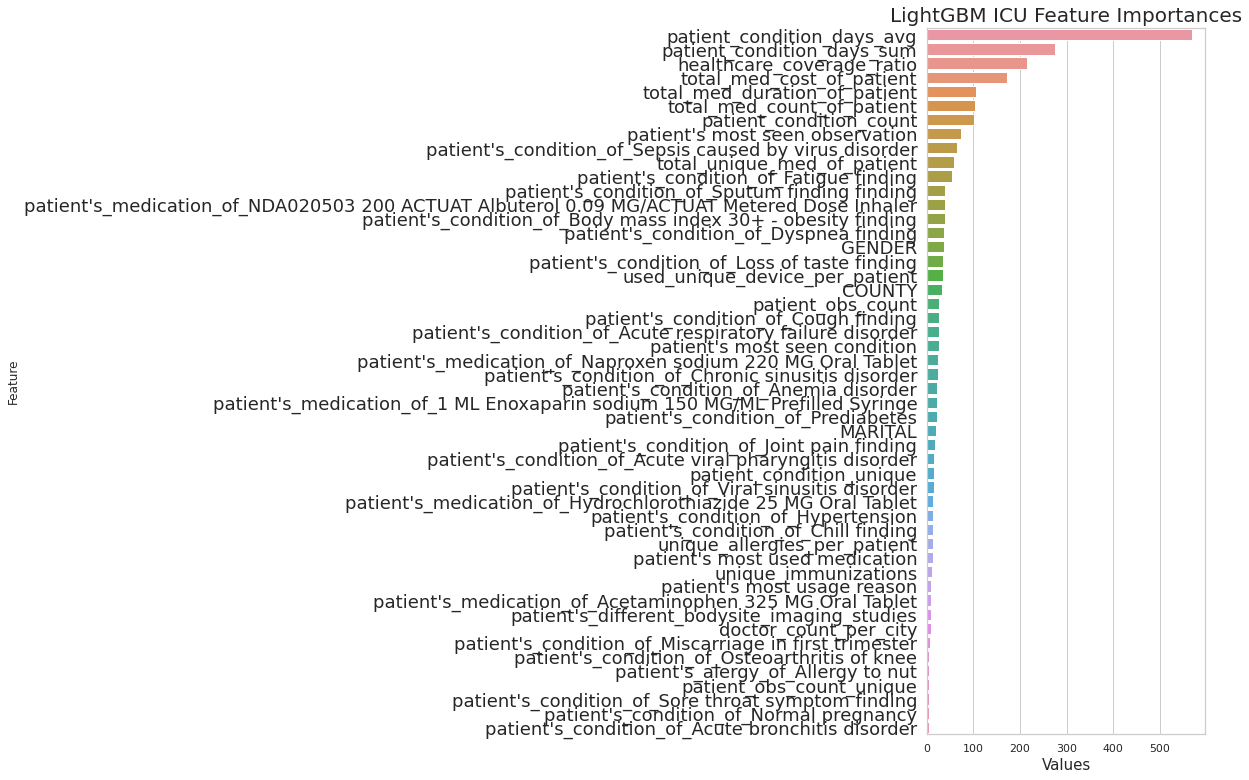

<Figure size 432x288 with 0 Axes>

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(17, 11))
p = sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:50])
_, ylabels = plt.yticks()
p.set_yticklabels(ylabels, size=18)
p.set_xlabel("Values", size = 15)

plt.title('LightGBM ICU Feature Importances', fontsize = 20)
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importance-hospital.png')

In [59]:
top50_features = feature_imp.sort_values("Value", ascending = False)[:50].Feature.values.tolist()
reduced_categorical_features = []
reduced_numerical_features = []
for i in top50_features:
  if i in CATEGORICAL_FEATURES:
    reduced_categorical_features.append(i)
  else:
    reduced_numerical_features.append(i)

In [60]:
FEATURES = list(reduced_numerical_features) + list(reduced_categorical_features)

In [61]:
X = train.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES]
y = train.duration
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state = 42)

model = lgb.LGBMRegressor()
model.fit(X_train, y_train, categorical_feature=reduced_categorical_features)

preds = model.predict(X_val)
preds[preds<0] = 0
val_result = mean_squared_error(y_val, preds, squared= False)
val_result

1.1621597168685827

In [62]:
model.fit(X, y)
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
real_preds = model.predict(test.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES])
lgb_rmse = mean_squared_error(test.duration, real_preds, squared= False)
lgb_mae = mae(test.duration, real_preds)
lgb_r2 = r2_score(test.duration, real_preds)


lgb_rmse

1.7865000668911815

#### It's indeed performing a bit better than initial model, by looking at both validation and test result we can say that

#### Let's tune some hyperparameters!

In [63]:
### Parameter Optimization
params = {
        'min_child_weight': [1, 5, 10,15],
        'colsample_bytree': [0.5, 0.7, 0.99],
        'num_leaves': [4,8,16,32,64,80],
        'num_iterations': [100,500,1000],
        'max_depth': [3, 4, 5,6,7, 10],
        "reg_lambda" : [0.2,0.5, 1, 1.5]
        }
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
param_comb = 10

kf = KFold(n_splits = 5)

random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=10, scoring='neg_mean_squared_error',  cv=kf.split(X,y), verbose=1, random_state=42 )

# Here we go
random_search.fit(X, y)
import lightgbm as lgb

model = lgb.LGBMRegressor(**random_search.best_params_)
model.fit(X_train, y_train, categorical_feature=reduced_categorical_features)

preds = model.predict(X_val)
val_result2 = mean_squared_error(y_val, preds, squared= False)
val_result2
print(random_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'reg_lambda': 1.5, 'num_leaves': 4, 'num_iterations': 100, 'min_child_weight': 1, 'max_depth': 10, 'colsample_bytree': 0.7}


{'reg_lambda': 0.2, 'num_leaves': 8, 'num_iterations': 500, 'min_child_weight': 1, 'max_depth': 4, 'colsample_bytree': 0.99}

In [64]:
import lightgbm as lgb

model = lgb.LGBMRegressor(**random_search.best_params_)
model.fit(X_train, y_train, categorical_feature=reduced_categorical_features)

preds = model.predict(X_val)
val_result2 = mean_squared_error(y_val, preds, squared= False)
print("Validation Result {}".format(val_result2))
##Test
model.fit(X, y)

real_preds = model.predict(test.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES])
lgb_tuned_rmse = mean_squared_error(test.duration, real_preds, squared= False)
lgb_tuned_mae = mae(test.duration, real_preds)
lgb_tuned_r2 = r2_score(test.duration, real_preds)
print("Test Result {}".format(lgb_tuned_rmse))

Validation Result 1.1548531571170593
Test Result 1.7475517025718756


In [65]:
df["start_month"] = df.icu_start.dt.month
df["start_week"] = df.icu_start.dt.week
df["start_day"] = df.icu_start.dt.dayofyear

test["start_month"] = test.icu_start.dt.month
test["start_week"] = test.icu_start.dt.week
test["start_day"] = test.icu_start.dt.dayofyear

Text(0, 0.5, '% difference between real values and predictions')

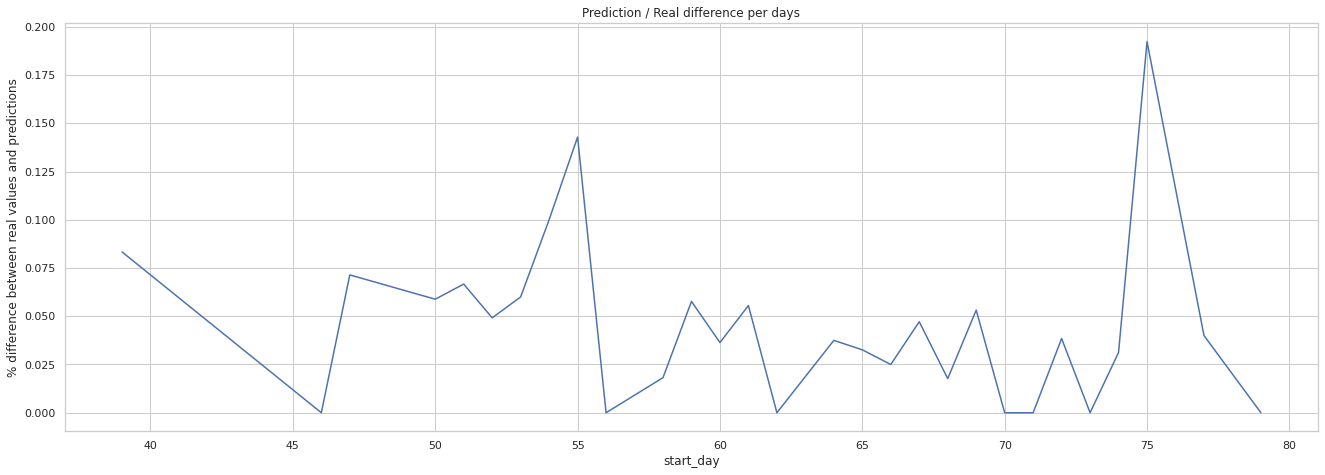

In [66]:
test["preds"] = real_preds
test["daily_preds_sum"] = test.groupby("start_day")["preds"].transform("sum").astype(int)
test["daily_real_sum"] = test.groupby("start_day")["duration"].transform("sum")
temp = test.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions")

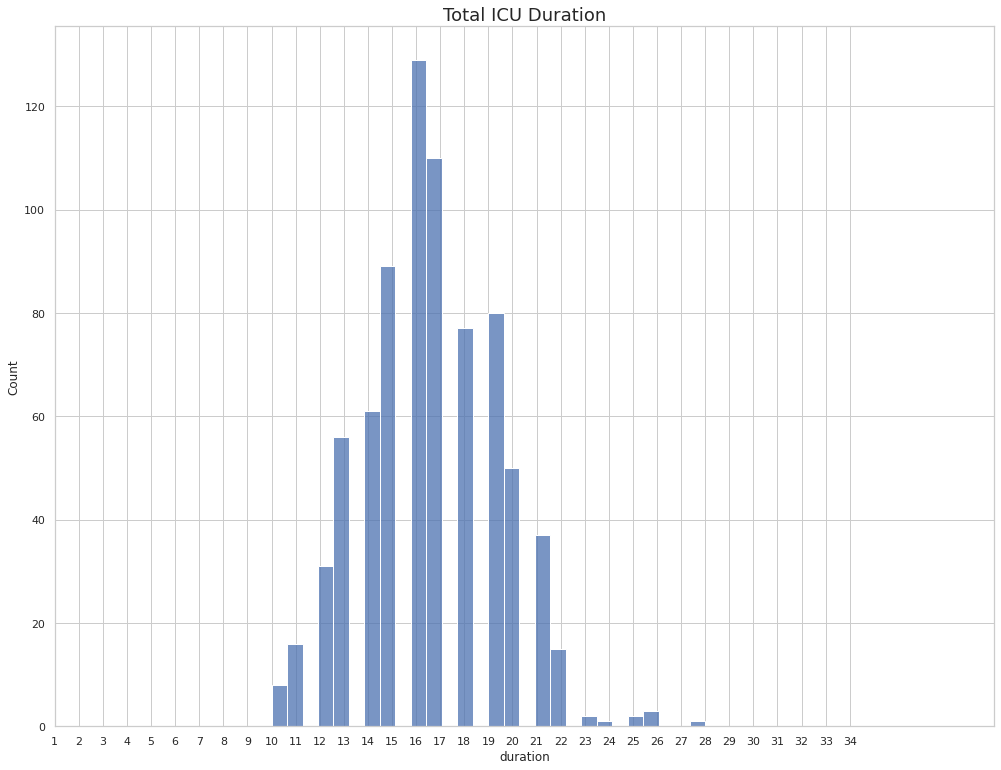

In [67]:
plt.figure(figsize = (15,12))
sns.histplot(data = df, x = "duration")
plt.xticks(np.arange(1,35,1))
plt.xlim(1,40)
plt.title('Total ICU Duration', fontsize = 18)
plt.show()

Text(0, 0.5, 'frequency')

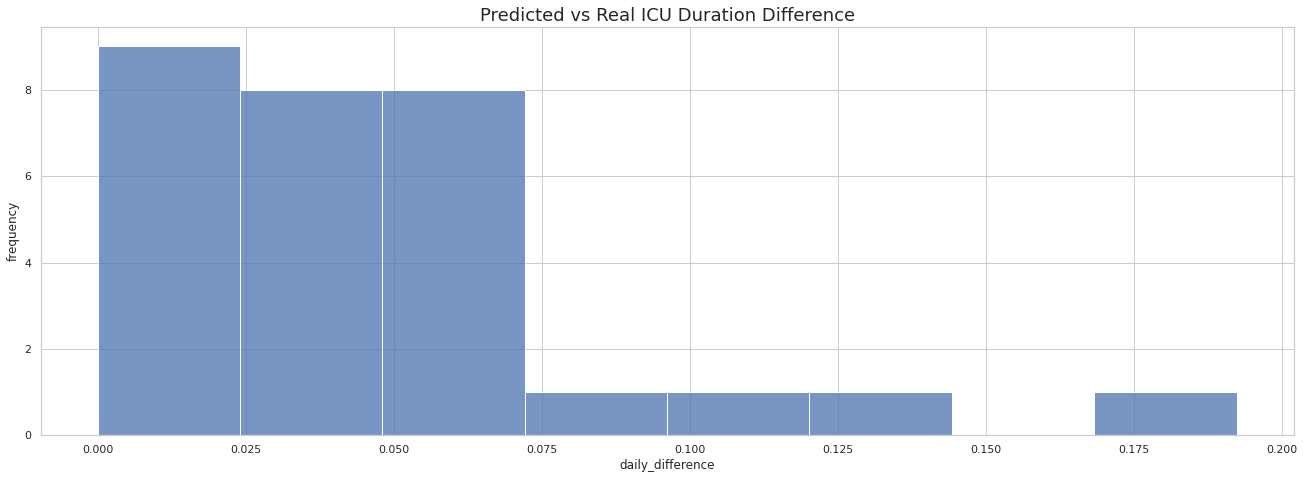

In [68]:
plt.figure(figsize = (20,7))
sns.histplot(data = temp, x = "daily_difference")
plt.title("Predicted vs Real ICU Duration Difference", fontsize = 18)
plt.ylabel("frequency")

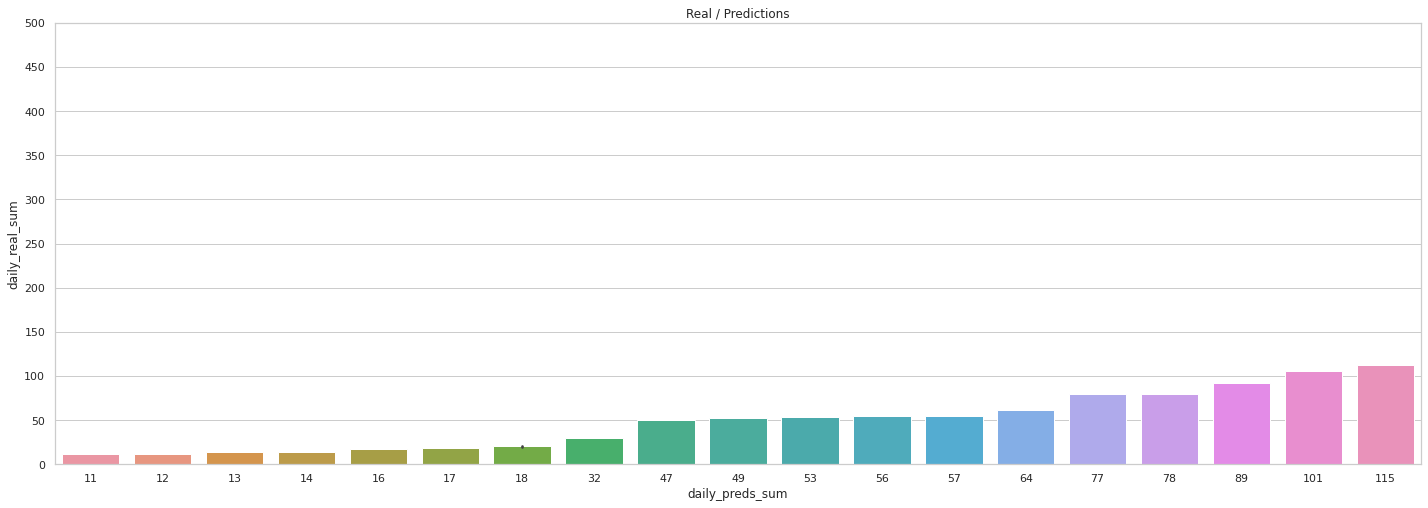

In [69]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20])
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions")
plt.show()

Text(0.5, 1.0, 'Daily differences between real values and predictions')

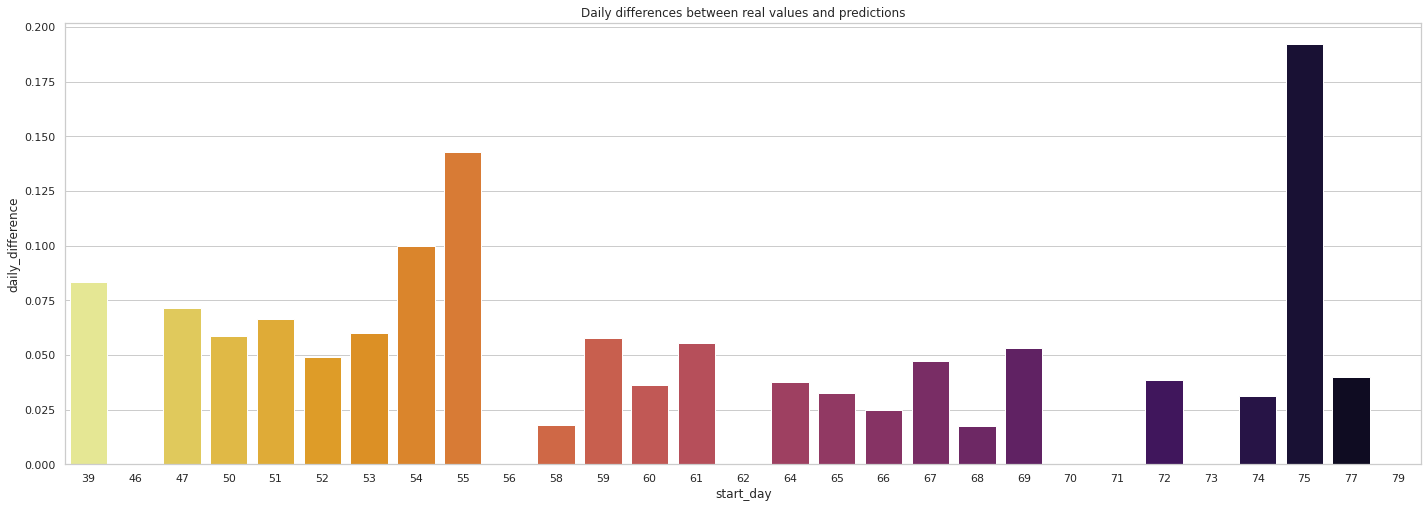

In [70]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions")

### FT - Transformer Models

In [71]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.6 MB/s eta 0:00:00


In [72]:
!pip install tabtransformertf


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [73]:
import math
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
import tensorflow_addons as tfa
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')


from tensorflow.keras.callbacks import EarlyStopping

from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
from tabtransformertf.utils.preprocessing import df_to_dataset

#import catboost as cb
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

def cat_analyser(data, col, freq_limit = None):
    if freq_limit == None:
        freq_limit = data[col].nunique()
        if freq_limit >= 12:
            freq_limit = 12
    df_ = data.copy()
    sns.set(rc = {'axes.facecolor': 'gainsboro',
                  'figure.facecolor': 'gainsboro'})
    if freq_limit < 6 or col == "Year":
        if df_[col].nunique() > freq_limit:
            df_ = df_.loc[df_[col].isin(df_[col].value_counts(). \
                                        keys()[:freq_limit].tolist())]
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,7))
        plt.tight_layout()
        #fig.suptitle(col, fontsize = 16)
        a = sns.countplot(data = df_,
                    x = col,
                    ax = ax[0],
                    palette= "viridis",
                    order =  df_[col].value_counts().index)
        a.set_title(col, fontsize = 15)
        ax[0].set_xlabel('')
        pie_cmap = plt.get_cmap("Set3")
        normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) 
        data[col].value_counts()[:freq_limit].plot.pie(autopct = '%1.1f%%',
                                        textprops = {'fontsize': 12},
                                        ax = ax[1],
                                        colors = pie_cmap(normalize(df_[col].value_counts())))
        ax[1].set_ylabel('')
    
        plt.show()
        sns.reset_orig()
    else:
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, freq_limit*1.5))
        #ax.set_title(col, fontsize = 16)
        a = sns.countplot(data = df_,
                    y = col,
                    ax = ax[0],
                    palette= "viridis",
                    order =  df_[col].value_counts()[:freq_limit].index)
        a.tick_params(axis = "x", rotation = 90)
        a.set_title(col, fontsize = 15)
        ax[0].set_xlabel('')
        pie_cmap = plt.get_cmap("Set3")
        normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) 
        data[col].value_counts()[:freq_limit].plot.pie(autopct = '%1.1f%%',
                                        textprops = {'fontsize': 12},
                                        ax = ax[1],
                                        colors = pie_cmap(normalize(df_[col].value_counts())))
        ax[1].set_ylabel('')
        plt.show()
        plt.tight_layout()
        sns.reset_orig()

In [74]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')



In [75]:
data = df.copy()
data = data.loc[data.duration > 0].reset_index(drop = True)

In [76]:
y = data['duration']
LABEL = "duration"

In [77]:
test_data = data.loc[data.dataset == "test"].drop(["dataset"],1).reset_index(drop = True)
train_data = data.loc[data.dataset == "train"].drop(["dataset"],1).reset_index(drop = True)

In [78]:
CATEGORICAL_FEATURES = reduced_categorical_features
NUMERIC_FEATURES = reduced_numerical_features

In [79]:
CATEGORICAL_FEATURES

["patient's most seen observation",
 'GENDER',
 'COUNTY',
 "patient's most seen condition",
 'MARITAL',
 "patient's most used medication",
 "patient's most usage reason"]

In [80]:
NUMERIC_FEATURES

['patient_condition_days_avg',
 'patient_condition_days_sum',
 'healthcare_coverage_ratio',
 'total_med_cost_of_patient',
 'total_med_duration_of_patient',
 'total_med_count_of_patient',
 'patient_condition_count',
 "patient's_condition_of_Sepsis caused by virus disorder",
 'total_unique_med_of_patient',
 "patient's_condition_of_Fatigue finding",
 "patient's_condition_of_Sputum finding finding",
 "patient's_medication_of_NDA020503 200 ACTUAT Albuterol 0.09 MG/ACTUAT Metered Dose Inhaler",
 "patient's_condition_of_Body mass index 30+ - obesity finding",
 "patient's_condition_of_Dyspnea finding",
 "patient's_condition_of_Loss of taste finding",
 'used_unique_device_per_patient',
 'patient_obs_count',
 "patient's_condition_of_Cough finding",
 "patient's_condition_of_Acute respiratory failure disorder",
 "patient's_medication_of_Naproxen sodium 220 MG Oral Tablet",
 "patient's_condition_of_Chronic sinusitis disorder",
 "patient's_condition_of_Anemia disorder",
 "patient's_medication_of_1 M

In [81]:
# Set data types
train_data[CATEGORICAL_FEATURES] = train_data[CATEGORICAL_FEATURES].astype(str)
test_data[CATEGORICAL_FEATURES] = test_data[CATEGORICAL_FEATURES].astype(str)

train_data[NUMERIC_FEATURES] = train_data[NUMERIC_FEATURES].astype(float)
test_data[NUMERIC_FEATURES] = test_data[NUMERIC_FEATURES].astype(float)

In [82]:
# Train/test split
X_train, X_val = train_test_split(train_data, test_size=0.2)

In [83]:
sc = StandardScaler()
X_train.loc[:, NUMERIC_FEATURES] = sc.fit_transform(X_train[NUMERIC_FEATURES])
X_val.loc[:, NUMERIC_FEATURES] = sc.transform(X_val[NUMERIC_FEATURES])
test_data.loc[:, NUMERIC_FEATURES] = sc.transform(test_data[NUMERIC_FEATURES])

In [84]:
train_dataset = df_to_dataset(X_train[FEATURES + [LABEL]], LABEL)
val_dataset = df_to_dataset(X_val[FEATURES + [LABEL]], LABEL, shuffle=False)  # No shuffle
test_dataset = df_to_dataset(test_data[FEATURES + [LABEL]], shuffle=False) # No target, no shuffle

In [85]:
ft_linear_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='linear',
    embedding_dim=32,
    depth=4,
    heads=8,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=True
)

# Pass th encoder to the model
ft_linear_transformer = FTTransformer(
    encoder=ft_linear_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 150

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_linear_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_linear_history = ft_linear_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/150
2/2 [==============================] - 14s 879ms/step - loss: 243.2940 - output_loss: 243.2940 - output_rmse: 15.5979 - val_loss: 152.5861 - val_output_loss: 152.5861 - val_output_rmse: 12.3526
Epoch 2/150
2/2 [==============================] - 0s 74ms/step - loss: 170.7786 - output_loss: 170.7786 - output_rmse: 13.0682 - val_loss: 117.7303 - val_output_loss: 117.7303 - val_output_rmse: 10.8504
Epoch 3/150
2/2 [==============================] - 0s 66ms/step - loss: 134.3851 - output_loss: 134.3851 - output_rmse: 11.5925 - val_loss: 104.9199 - val_output_loss: 104.9199 - val_output_rmse: 10.2430
Epoch 4/150
2/2 [==============================] - 0s 66ms/step - loss: 118.1175 - output_loss: 118.1175 - output_rmse: 10.8682 - val_loss: 96.3004 - val_output_loss: 96.3004 - val_output_rmse: 9.8133
Epoch 5/150
2/2 [==============================] - 0s 69ms/step - loss: 106.0079 - output_loss: 106.0079 - output_rmse: 10.2960 - val_loss: 89.7012 - val_output_loss: 89.7012 - val_outp

In [86]:
ft_periodic_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='periodic',
    numerical_bins=32,
    embedding_dim=16,
    depth=3,
    heads=6,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=True
)

# Pass th encoder to the model
ft_periodic_transformer = FTTransformer(
    encoder=ft_periodic_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 150

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_periodic_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_periodic_history = ft_periodic_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/150
2/2 [==============================] - 6s 707ms/step - loss: 232.4973 - output_loss: 232.4973 - output_rmse: 15.2479 - val_loss: 174.2917 - val_output_loss: 174.2917 - val_output_rmse: 13.2020
Epoch 2/150
2/2 [==============================] - 0s 56ms/step - loss: 198.4382 - output_loss: 198.4382 - output_rmse: 14.0868 - val_loss: 148.8813 - val_output_loss: 148.8813 - val_output_rmse: 12.2017
Epoch 3/150
2/2 [==============================] - 0s 58ms/step - loss: 179.3388 - output_loss: 179.3388 - output_rmse: 13.3917 - val_loss: 134.3866 - val_output_loss: 134.3866 - val_output_rmse: 11.5925
Epoch 4/150
2/2 [==============================] - 0s 64ms/step - loss: 167.8125 - output_loss: 167.8125 - output_rmse: 12.9542 - val_loss: 124.4081 - val_output_loss: 124.4081 - val_output_rmse: 11.1538
Epoch 5/150
2/2 [==============================] - 0s 55ms/step - loss: 154.1754 - output_loss: 154.1754 - output_rmse: 12.4167 - val_loss: 116.8139 - val_output_loss: 116.8139 - val_

In [87]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score
linear_test_preds = ft_linear_transformer.predict(test_dataset)
linear_rms = mean_squared_error(test_data[LABEL], linear_test_preds['output'].ravel(), squared=False)
linear_mae = mae(test_data[LABEL], linear_test_preds['output'].ravel())
linear_mape = mape(test_data[LABEL], linear_test_preds['output'].ravel())
linear_r2 = r2_score(test_data[LABEL], linear_test_preds['output'])

periodic_test_preds = ft_periodic_transformer.predict(test_dataset)
periodic_rms = mean_squared_error(test_data[LABEL], periodic_test_preds['output'].ravel(), squared=False)
period_mae = mae(test_data[LABEL], periodic_test_preds['output'].ravel())
periodic_r2 = r2_score(test_data[LABEL], linear_test_preds['output'].ravel())


1/1 [==============================] - 1s 603ms/step


In [88]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 10.1 MB/s eta 0:00:00


### Parameter Optimization for Transformer Models

In [89]:
import optuna
import gc

def objective(trial):
    ft_encoder = FTTransformerEncoder(
        numerical_features = NUMERIC_FEATURES,
        categorical_features =CATEGORICAL_FEATURES,
        numerical_data = X_train[NUMERIC_FEATURES].values,
        categorical_data = X_train[CATEGORICAL_FEATURES].values,
        y = X_train[LABEL].values,
        numerical_embedding_type='periodic',
        numerical_bins=trial.suggest_int('numerical_bins', 20, 200),
        embedding_dim=trial.suggest_int('embedding_dim', 8, 100),
        depth=trial.suggest_int('depth', 1, 6),
        heads=trial.suggest_int('heads', 2, 8),
        attn_dropout=trial.suggest_float('attn_dropout', 0., 0.5),
        ff_dropout=trial.suggest_float('ff_dropout', 0., 0.5),
        explainable=True
    )


    # Pass th encoder to the model
    ft_transformer = FTTransformer(
        encoder=ft_encoder,
        out_dim=1,
        out_activation="relu"
    )

    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.00001
    NUM_EPOCHS = 150

    optimizer = tfa.optimizers.AdamW(
            learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        )

    ft_transformer.compile(
        optimizer = optimizer,
        loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
        metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
    )

    early = EarlyStopping(monitor="val_output_loss", mode="min", patience=20, restore_best_weights=True)
    callback_list = [early]

    ft_history = ft_transformer.fit(
        train_dataset, 
        epochs=NUM_EPOCHS, 
        validation_data=val_dataset,
        callbacks=callback_list
    ) 
    
    preds = ft_transformer.predict(test_dataset)
    
    rmse = mean_squared_error(test_data[LABEL], preds['output'].ravel(),squared=False)
    gc.collect()
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-01-26 07:48:42,155] A new study created in memory with name: no-name-c8700c9b-202f-4f17-ab32-c435199e63fc


Epoch 1/150
2/2 [==============================] - 5s 787ms/step - loss: 281.4365 - output_loss: 281.4365 - output_rmse: 16.7761 - val_loss: 276.0799 - val_output_loss: 276.0799 - val_output_rmse: 16.6157
Epoch 2/150
2/2 [==============================] - 0s 67ms/step - loss: 279.7419 - output_loss: 279.7419 - output_rmse: 16.7255 - val_loss: 266.7660 - val_output_loss: 266.7660 - val_output_rmse: 16.3330
Epoch 3/150
2/2 [==============================] - 0s 95ms/step - loss: 277.6150 - output_loss: 277.6150 - output_rmse: 16.6618 - val_loss: 260.2959 - val_output_loss: 260.2959 - val_output_rmse: 16.1337
Epoch 4/150
2/2 [==============================] - 0s 93ms/step - loss: 273.1917 - output_loss: 273.1917 - output_rmse: 16.5285 - val_loss: 253.8450 - val_output_loss: 253.8450 - val_output_rmse: 15.9325
Epoch 5/150
2/2 [==============================] - 0s 66ms/step - loss: 268.0734 - output_loss: 268.0734 - output_rmse: 16.3729 - val_loss: 248.4170 - val_output_loss: 248.4170 - val_

[I 2023-01-26 07:49:09,193] Trial 0 finished with value: 3.0442987144493903 and parameters: {'numerical_bins': 20, 'embedding_dim': 19, 'depth': 2, 'heads': 4, 'attn_dropout': 0.4687528066755305, 'ff_dropout': 0.40573003512697275}. Best is trial 0 with value: 3.0442987144493903.


Epoch 1/150
2/2 [==============================] - 7s 847ms/step - loss: 280.2146 - output_loss: 280.2146 - output_rmse: 16.7396 - val_loss: 277.0885 - val_output_loss: 277.0885 - val_output_rmse: 16.6460
Epoch 2/150
2/2 [==============================] - 0s 67ms/step - loss: 274.3470 - output_loss: 274.3470 - output_rmse: 16.5634 - val_loss: 258.9493 - val_output_loss: 258.9493 - val_output_rmse: 16.0919
Epoch 3/150
2/2 [==============================] - 0s 60ms/step - loss: 265.3215 - output_loss: 265.3215 - output_rmse: 16.2887 - val_loss: 237.6493 - val_output_loss: 237.6493 - val_output_rmse: 15.4159
Epoch 4/150
2/2 [==============================] - 0s 69ms/step - loss: 251.5611 - output_loss: 251.5611 - output_rmse: 15.8607 - val_loss: 215.4316 - val_output_loss: 215.4316 - val_output_rmse: 14.6776
Epoch 5/150
2/2 [==============================] - 0s 67ms/step - loss: 238.2835 - output_loss: 238.2835 - output_rmse: 15.4364 - val_loss: 200.0073 - val_output_loss: 200.0073 - val_

[I 2023-01-26 07:49:34,227] Trial 1 finished with value: 3.0439235252930326 and parameters: {'numerical_bins': 197, 'embedding_dim': 13, 'depth': 4, 'heads': 3, 'attn_dropout': 0.2339302750019528, 'ff_dropout': 0.3361467644629388}. Best is trial 1 with value: 3.0439235252930326.


Epoch 1/150
2/2 [==============================] - 4s 609ms/step - loss: 281.7419 - output_loss: 281.7419 - output_rmse: 16.7852 - val_loss: 278.0941 - val_output_loss: 278.0941 - val_output_rmse: 16.6762
Epoch 2/150
2/2 [==============================] - 0s 49ms/step - loss: 280.1368 - output_loss: 280.1368 - output_rmse: 16.7373 - val_loss: 264.5443 - val_output_loss: 264.5443 - val_output_rmse: 16.2648
Epoch 3/150
2/2 [==============================] - 0s 46ms/step - loss: 268.4760 - output_loss: 268.4760 - output_rmse: 16.3852 - val_loss: 253.6425 - val_output_loss: 253.6425 - val_output_rmse: 15.9262
Epoch 4/150
2/2 [==============================] - 0s 50ms/step - loss: 257.2620 - output_loss: 257.2620 - output_rmse: 16.0394 - val_loss: 240.1809 - val_output_loss: 240.1809 - val_output_rmse: 15.4978
Epoch 5/150
2/2 [==============================] - 0s 47ms/step - loss: 243.0598 - output_loss: 243.0598 - output_rmse: 15.5904 - val_loss: 228.2269 - val_output_loss: 228.2269 - val_

1/1 [==============================] - 1s 507ms/step


[I 2023-01-26 07:49:54,934] Trial 2 finished with value: 3.044659722363131 and parameters: {'numerical_bins': 72, 'embedding_dim': 19, 'depth': 2, 'heads': 5, 'attn_dropout': 0.14310917601185075, 'ff_dropout': 0.010553857791896548}. Best is trial 1 with value: 3.0439235252930326.


Epoch 1/150
2/2 [==============================] - 7s 894ms/step - loss: 277.5813 - output_loss: 277.5813 - output_rmse: 16.6608 - val_loss: 111.1610 - val_output_loss: 111.1610 - val_output_rmse: 10.5433
Epoch 2/150
2/2 [==============================] - 0s 82ms/step - loss: 150.0252 - output_loss: 150.0252 - output_rmse: 12.2485 - val_loss: 59.3004 - val_output_loss: 59.3004 - val_output_rmse: 7.7007
Epoch 3/150
2/2 [==============================] - 0s 82ms/step - loss: 81.4553 - output_loss: 81.4553 - output_rmse: 9.0253 - val_loss: 35.8914 - val_output_loss: 35.8914 - val_output_rmse: 5.9909
Epoch 4/150
2/2 [==============================] - 0s 80ms/step - loss: 47.9721 - output_loss: 47.9721 - output_rmse: 6.9262 - val_loss: 24.5808 - val_output_loss: 24.5808 - val_output_rmse: 4.9579
Epoch 5/150
2/2 [==============================] - 0s 82ms/step - loss: 31.7863 - output_loss: 31.7863 - output_rmse: 5.6379 - val_loss: 18.6941 - val_output_loss: 18.6941 - val_output_rmse: 4.3237


1/1 [==============================] - 1s 730ms/step


[I 2023-01-26 07:50:18,775] Trial 3 finished with value: 3.043383435734237 and parameters: {'numerical_bins': 163, 'embedding_dim': 95, 'depth': 4, 'heads': 5, 'attn_dropout': 0.22664657762117657, 'ff_dropout': 0.3649731518029825}. Best is trial 3 with value: 3.043383435734237.


Epoch 1/150
2/2 [==============================] - 4s 599ms/step - loss: 251.7408 - output_loss: 251.7408 - output_rmse: 15.8663 - val_loss: 174.8683 - val_output_loss: 174.8683 - val_output_rmse: 13.2238
Epoch 2/150
2/2 [==============================] - 0s 54ms/step - loss: 182.8481 - output_loss: 182.8481 - output_rmse: 13.5221 - val_loss: 149.9735 - val_output_loss: 149.9735 - val_output_rmse: 12.2464
Epoch 3/150
2/2 [==============================] - 0s 50ms/step - loss: 158.7464 - output_loss: 158.7464 - output_rmse: 12.5995 - val_loss: 128.5981 - val_output_loss: 128.5981 - val_output_rmse: 11.3401
Epoch 4/150
2/2 [==============================] - 0s 54ms/step - loss: 138.8683 - output_loss: 138.8683 - output_rmse: 11.7842 - val_loss: 111.8277 - val_output_loss: 111.8277 - val_output_rmse: 10.5749
Epoch 5/150
2/2 [==============================] - 0s 49ms/step - loss: 121.9290 - output_loss: 121.9290 - output_rmse: 11.0421 - val_loss: 99.4809 - val_output_loss: 99.4809 - val_ou

[I 2023-01-26 07:50:31,138] Trial 4 finished with value: 3.041667723157261 and parameters: {'numerical_bins': 72, 'embedding_dim': 68, 'depth': 2, 'heads': 3, 'attn_dropout': 0.24952301799684823, 'ff_dropout': 0.1184722824262559}. Best is trial 4 with value: 3.041667723157261.


Epoch 1/150
2/2 [==============================] - 9s 1s/step - loss: 250.3248 - output_loss: 250.3248 - output_rmse: 15.8217 - val_loss: 67.6507 - val_output_loss: 67.6507 - val_output_rmse: 8.2250
Epoch 2/150
2/2 [==============================] - 0s 88ms/step - loss: 81.3066 - output_loss: 81.3066 - output_rmse: 9.0170 - val_loss: 28.8458 - val_output_loss: 28.8458 - val_output_rmse: 5.3708
Epoch 3/150
2/2 [==============================] - 0s 90ms/step - loss: 36.1083 - output_loss: 36.1083 - output_rmse: 6.0090 - val_loss: 14.0904 - val_output_loss: 14.0904 - val_output_rmse: 3.7537
Epoch 4/150
2/2 [==============================] - 0s 90ms/step - loss: 17.6040 - output_loss: 17.6040 - output_rmse: 4.1957 - val_loss: 9.0208 - val_output_loss: 9.0208 - val_output_rmse: 3.0035
Epoch 5/150
2/2 [==============================] - 0s 88ms/step - loss: 10.4242 - output_loss: 10.4242 - output_rmse: 3.2287 - val_loss: 7.7051 - val_output_loss: 7.7051 - val_output_rmse: 2.7758
Epoch 6/150
2

[I 2023-01-26 07:51:05,437] Trial 5 finished with value: 2.1797619401382913 and parameters: {'numerical_bins': 104, 'embedding_dim': 97, 'depth': 6, 'heads': 2, 'attn_dropout': 0.4479943455126325, 'ff_dropout': 0.11680334173996865}. Best is trial 5 with value: 2.1797619401382913.


Epoch 1/150
2/2 [==============================] - 6s 732ms/step - loss: 260.0539 - output_loss: 260.0539 - output_rmse: 16.1262 - val_loss: 182.8464 - val_output_loss: 182.8464 - val_output_rmse: 13.5221
Epoch 2/150
2/2 [==============================] - 0s 68ms/step - loss: 194.2491 - output_loss: 194.2491 - output_rmse: 13.9373 - val_loss: 125.2917 - val_output_loss: 125.2917 - val_output_rmse: 11.1934
Epoch 3/150
2/2 [==============================] - 0s 63ms/step - loss: 141.0900 - output_loss: 141.0900 - output_rmse: 11.8781 - val_loss: 95.9587 - val_output_loss: 95.9587 - val_output_rmse: 9.7959
Epoch 4/150
2/2 [==============================] - 0s 62ms/step - loss: 107.9649 - output_loss: 107.9649 - output_rmse: 10.3906 - val_loss: 69.7528 - val_output_loss: 69.7528 - val_output_rmse: 8.3518
Epoch 5/150
2/2 [==============================] - 0s 61ms/step - loss: 79.8370 - output_loss: 79.8370 - output_rmse: 8.9352 - val_loss: 52.0778 - val_output_loss: 52.0778 - val_output_rmse

[I 2023-01-26 07:51:22,815] Trial 6 finished with value: 3.0410782556347704 and parameters: {'numerical_bins': 128, 'embedding_dim': 47, 'depth': 3, 'heads': 7, 'attn_dropout': 0.452397750235751, 'ff_dropout': 0.17610070862637306}. Best is trial 5 with value: 2.1797619401382913.


Epoch 1/150
2/2 [==============================] - 6s 730ms/step - loss: 229.1620 - output_loss: 229.1620 - output_rmse: 15.1381 - val_loss: 127.9537 - val_output_loss: 127.9537 - val_output_rmse: 11.3117
Epoch 2/150
2/2 [==============================] - 0s 67ms/step - loss: 146.6622 - output_loss: 146.6622 - output_rmse: 12.1104 - val_loss: 92.1847 - val_output_loss: 92.1847 - val_output_rmse: 9.6013
Epoch 3/150
2/2 [==============================] - 0s 67ms/step - loss: 110.2085 - output_loss: 110.2085 - output_rmse: 10.4980 - val_loss: 68.2891 - val_output_loss: 68.2891 - val_output_rmse: 8.2637
Epoch 4/150
2/2 [==============================] - 0s 66ms/step - loss: 83.5633 - output_loss: 83.5633 - output_rmse: 9.1413 - val_loss: 52.6842 - val_output_loss: 52.6842 - val_output_rmse: 7.2584
Epoch 5/150
2/2 [==============================] - 0s 68ms/step - loss: 63.0256 - output_loss: 63.0256 - output_rmse: 7.9389 - val_loss: 42.1253 - val_output_loss: 42.1253 - val_output_rmse: 6.49

[I 2023-01-26 07:51:46,657] Trial 7 finished with value: 3.0447392095509684 and parameters: {'numerical_bins': 130, 'embedding_dim': 67, 'depth': 3, 'heads': 7, 'attn_dropout': 0.24933345131077062, 'ff_dropout': 0.2587614536619271}. Best is trial 5 with value: 2.1797619401382913.


Epoch 1/150
2/2 [==============================] - 3s 459ms/step - loss: 273.8946 - output_loss: 273.8946 - output_rmse: 16.5498 - val_loss: 257.8049 - val_output_loss: 257.8049 - val_output_rmse: 16.0563
Epoch 2/150
2/2 [==============================] - 0s 37ms/step - loss: 264.3618 - output_loss: 264.3618 - output_rmse: 16.2592 - val_loss: 247.6216 - val_output_loss: 247.6216 - val_output_rmse: 15.7360
Epoch 3/150
2/2 [==============================] - 0s 36ms/step - loss: 256.0655 - output_loss: 256.0655 - output_rmse: 16.0020 - val_loss: 243.5478 - val_output_loss: 243.5478 - val_output_rmse: 15.6060
Epoch 4/150
2/2 [==============================] - 0s 37ms/step - loss: 251.7919 - output_loss: 251.7919 - output_rmse: 15.8680 - val_loss: 240.3674 - val_output_loss: 240.3674 - val_output_rmse: 15.5038
Epoch 5/150
2/2 [==============================] - 0s 39ms/step - loss: 248.0904 - output_loss: 248.0904 - output_rmse: 15.7509 - val_loss: 237.1650 - val_output_loss: 237.1650 - val_

[I 2023-01-26 07:52:02,291] Trial 8 finished with value: 3.04431193913601 and parameters: {'numerical_bins': 30, 'embedding_dim': 13, 'depth': 1, 'heads': 6, 'attn_dropout': 0.0868040366296674, 'ff_dropout': 0.22621858910798953}. Best is trial 5 with value: 2.1797619401382913.


Epoch 1/150
2/2 [==============================] - 8s 980ms/step - loss: 257.3754 - output_loss: 257.3754 - output_rmse: 16.0429 - val_loss: 93.5488 - val_output_loss: 93.5488 - val_output_rmse: 9.6721
Epoch 2/150
2/2 [==============================] - 0s 89ms/step - loss: 110.0391 - output_loss: 110.0391 - output_rmse: 10.4900 - val_loss: 54.7999 - val_output_loss: 54.7999 - val_output_rmse: 7.4027
Epoch 3/150
2/2 [==============================] - 0s 86ms/step - loss: 65.1442 - output_loss: 65.1442 - output_rmse: 8.0712 - val_loss: 39.3496 - val_output_loss: 39.3496 - val_output_rmse: 6.2729
Epoch 4/150
2/2 [==============================] - 0s 92ms/step - loss: 44.9882 - output_loss: 44.9882 - output_rmse: 6.7073 - val_loss: 30.7950 - val_output_loss: 30.7950 - val_output_rmse: 5.5493
Epoch 5/150
2/2 [==============================] - 0s 90ms/step - loss: 34.4406 - output_loss: 34.4406 - output_rmse: 5.8686 - val_loss: 25.4421 - val_output_loss: 25.4421 - val_output_rmse: 5.0440
Epo

[I 2023-01-26 07:52:21,374] Trial 9 finished with value: 3.0425517753706206 and parameters: {'numerical_bins': 28, 'embedding_dim': 84, 'depth': 5, 'heads': 5, 'attn_dropout': 0.06738274960684093, 'ff_dropout': 0.14425235148815424}. Best is trial 5 with value: 2.1797619401382913.


Number of finished trials: 10
Best trial: {'numerical_bins': 104, 'embedding_dim': 97, 'depth': 6, 'heads': 2, 'attn_dropout': 0.4479943455126325, 'ff_dropout': 0.11680334173996865}


In [90]:
ft_periodic_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='periodic',
    numerical_bins=104,
    embedding_dim=97,
    depth=1,
    heads=6,
    attn_dropout= 0.0463,
    ff_dropout= 0.0861,
    explainable=True
)

# Pass th encoder to the model
ft_periodic_encoder_transformer = FTTransformer(
    encoder=ft_periodic_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 250

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_periodic_encoder_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_periodic_history = ft_periodic_encoder_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/250
2/2 [==============================] - 4s 472ms/step - loss: 280.2300 - output_loss: 280.2300 - output_rmse: 16.7401 - val_loss: 207.4456 - val_output_loss: 207.4456 - val_output_rmse: 14.4030
Epoch 2/250
2/2 [==============================] - 0s 48ms/step - loss: 211.8501 - output_loss: 211.8501 - output_rmse: 14.5551 - val_loss: 168.4948 - val_output_loss: 168.4948 - val_output_rmse: 12.9806
Epoch 3/250
2/2 [==============================] - 0s 49ms/step - loss: 175.2517 - output_loss: 175.2517 - output_rmse: 13.2383 - val_loss: 143.0797 - val_output_loss: 143.0797 - val_output_rmse: 11.9616
Epoch 4/250
2/2 [==============================] - 0s 43ms/step - loss: 149.6732 - output_loss: 149.6732 - output_rmse: 12.2341 - val_loss: 125.8355 - val_output_loss: 125.8355 - val_output_rmse: 11.2176
Epoch 5/250
2/2 [==============================] - 0s 43ms/step - loss: 132.8666 - output_loss: 132.8666 - output_rmse: 11.5268 - val_loss: 113.2346 - val_output_loss: 113.2346 - val_

In [91]:
periodic_tuned_test_preds = ft_periodic_encoder_transformer.predict(test_dataset)
periodic_tuned_rms = mean_squared_error(test_data[LABEL], periodic_tuned_test_preds['output'].ravel(), squared=False)
periodic_tuned_mae = mae(test_data[LABEL], periodic_tuned_test_preds['output'].ravel())
periodic_tuned_r2 = r2_score(test_data[LABEL], periodic_tuned_test_preds['output'].ravel())


1/1 [==============================] - 0s 375ms/step


### Periodic Encoding FT Transformer Model Graphs

In [92]:
df["start_month"] = df.icu_start.dt.month
df["start_week"] = df.icu_start.dt.week
df["start_day"] = df.icu_start.dt.dayofyear

test["start_month"] = test.icu_start.dt.month
test["start_week"] = test.icu_start.dt.week
test["start_day"] = test.icu_start.dt.dayofyear

Text(0, 0.5, '% difference between real values and predictions ( Periodic Encoding FT )')

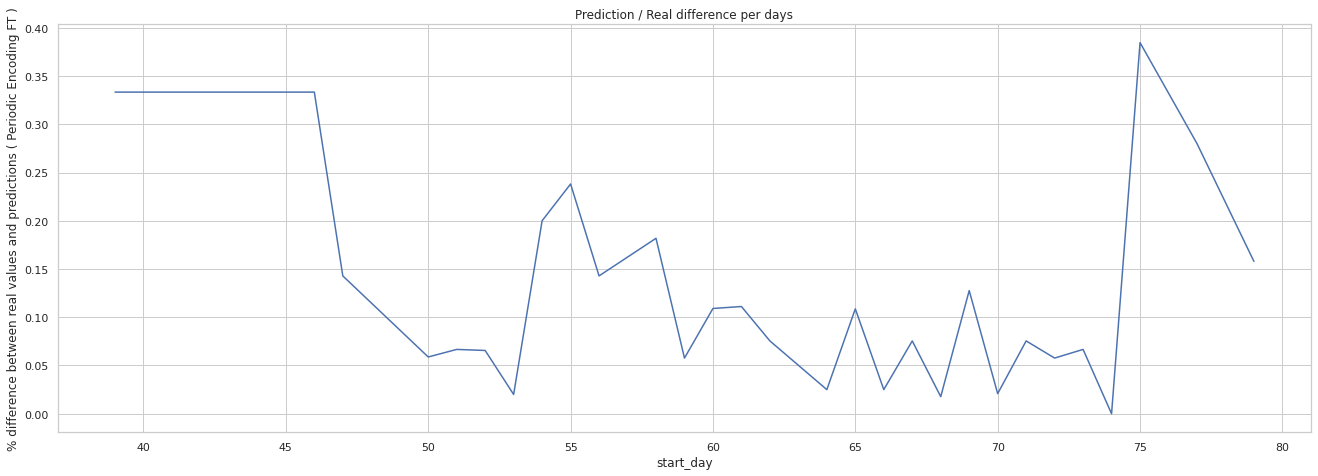

In [93]:
test_copy = df.loc[(df.dataset == "test") & (df.duration.notnull())].copy()
test_copy["preds"] = periodic_tuned_test_preds['output'].ravel()
test_copy["daily_preds_sum"] = test_copy.groupby("start_day")["preds"].transform("sum").astype(int)
test_copy["daily_real_sum"] = test_copy.groupby("start_day")["duration"].transform("sum")
temp = test_copy.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions ( Periodic Encoding FT )")

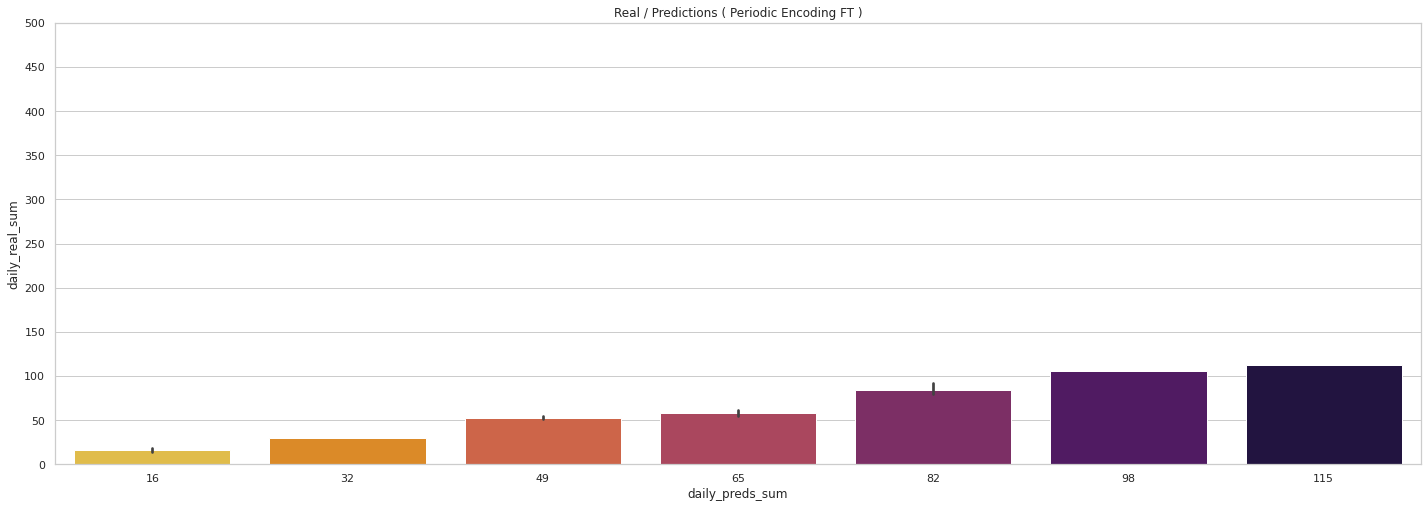

In [94]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20], palette = "inferno_r")
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions ( Periodic Encoding FT )")
plt.show()

Text(0.5, 1.0, 'Daily differences between real values and predictions ( Periodic Encoding FT )')

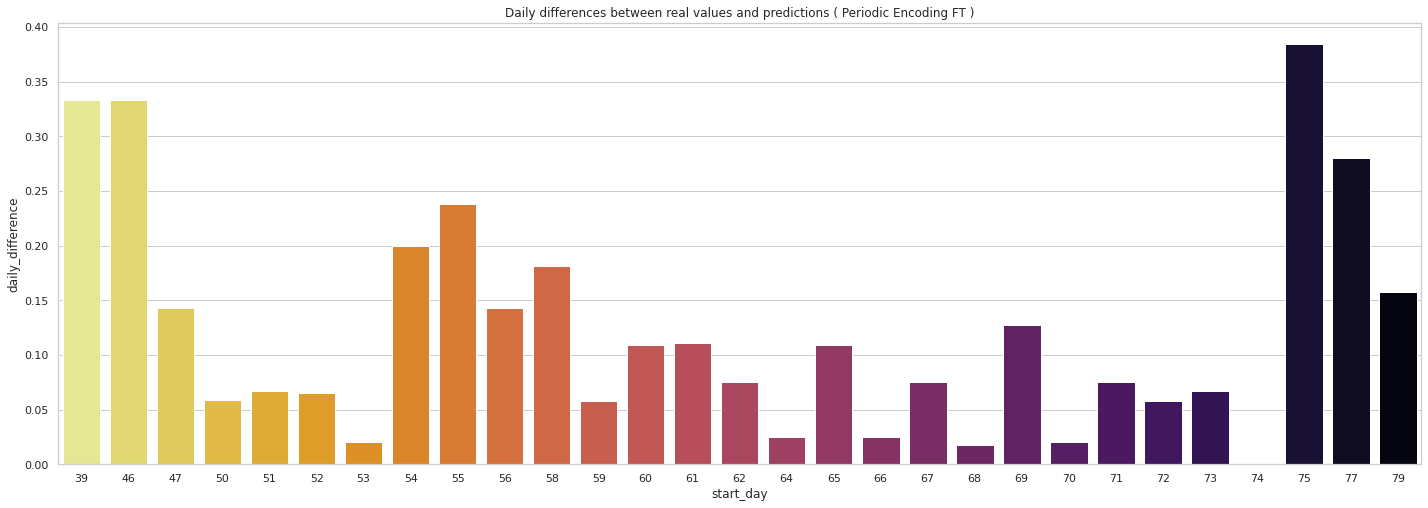

In [95]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions ( Periodic Encoding FT )")

### Linear Encoding Parameter Optimization

In [96]:
import optuna
import gc

def objective(trial):
    ft_encoder = FTTransformerEncoder(
        numerical_features = NUMERIC_FEATURES,
        categorical_features =CATEGORICAL_FEATURES,
        numerical_data = X_train[NUMERIC_FEATURES].values,
        categorical_data = X_train[CATEGORICAL_FEATURES].values,
        y = X_train[LABEL].values,
        numerical_embedding_type='linear',
        numerical_bins=trial.suggest_int('numerical_bins', 20, 200),
        embedding_dim=trial.suggest_int('embedding_dim', 8, 100),
        depth=trial.suggest_int('depth', 1, 6),
        heads=trial.suggest_int('heads', 2, 8),
        attn_dropout=trial.suggest_float('attn_dropout', 0., 0.5),
        ff_dropout=trial.suggest_float('ff_dropout', 0., 0.5),
        explainable=True
    )


    # Pass th encoder to the model
    ft_transformer = FTTransformer(
        encoder=ft_encoder,
        out_dim=1,
        out_activation="relu"
    )

    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.00001
    NUM_EPOCHS = 150

    optimizer = tfa.optimizers.AdamW(
            learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        )

    ft_transformer.compile(
        optimizer = optimizer,
        loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
        metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
    )

    early = EarlyStopping(monitor="val_output_loss", mode="min", patience=20, restore_best_weights=True)
    callback_list = [early]

    ft_history = ft_transformer.fit(
        train_dataset, 
        epochs=NUM_EPOCHS, 
        validation_data=val_dataset,
        callbacks=callback_list
    ) 
    
    preds = ft_transformer.predict(test_dataset)
    
    rmse = mean_squared_error(test_data[LABEL], preds['output'].ravel(),squared=False)
    gc.collect()
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-01-26 07:54:54,736] A new study created in memory with name: no-name-3fdeacd3-0cf9-48f5-bc70-dc6c60972124


Epoch 1/150
2/2 [==============================] - 5s 695ms/step - loss: 269.9659 - output_loss: 269.9659 - output_rmse: 16.4306 - val_loss: 142.6004 - val_output_loss: 142.6004 - val_output_rmse: 11.9415
Epoch 2/150
2/2 [==============================] - 0s 62ms/step - loss: 143.8033 - output_loss: 143.8033 - output_rmse: 11.9918 - val_loss: 86.2172 - val_output_loss: 86.2172 - val_output_rmse: 9.2853
Epoch 3/150
2/2 [==============================] - 0s 67ms/step - loss: 87.3262 - output_loss: 87.3262 - output_rmse: 9.3448 - val_loss: 59.8541 - val_output_loss: 59.8541 - val_output_rmse: 7.7365
Epoch 4/150
2/2 [==============================] - 0s 55ms/step - loss: 61.1683 - output_loss: 61.1683 - output_rmse: 7.8210 - val_loss: 47.8732 - val_output_loss: 47.8732 - val_output_rmse: 6.9190
Epoch 5/150
2/2 [==============================] - 0s 56ms/step - loss: 49.0591 - output_loss: 49.0591 - output_rmse: 7.0042 - val_loss: 41.2601 - val_output_loss: 41.2601 - val_output_rmse: 6.4234


[I 2023-01-26 07:55:20,111] Trial 0 finished with value: 1.8519501283845132 and parameters: {'numerical_bins': 142, 'embedding_dim': 93, 'depth': 3, 'heads': 2, 'attn_dropout': 0.16898121510144593, 'ff_dropout': 0.006178371638725033}. Best is trial 0 with value: 1.8519501283845132.


Epoch 1/150
2/2 [==============================] - 9s 1s/step - loss: 264.5635 - output_loss: 264.5635 - output_rmse: 16.2654 - val_loss: 244.2045 - val_output_loss: 244.2045 - val_output_rmse: 15.6270
Epoch 2/150
2/2 [==============================] - 0s 78ms/step - loss: 250.7234 - output_loss: 250.7234 - output_rmse: 15.8342 - val_loss: 239.9853 - val_output_loss: 239.9853 - val_output_rmse: 15.4915
Epoch 3/150
2/2 [==============================] - 0s 83ms/step - loss: 244.3930 - output_loss: 244.3930 - output_rmse: 15.6331 - val_loss: 237.3679 - val_output_loss: 237.3679 - val_output_rmse: 15.4067
Epoch 4/150
2/2 [==============================] - 0s 79ms/step - loss: 239.6265 - output_loss: 239.6265 - output_rmse: 15.4799 - val_loss: 233.7905 - val_output_loss: 233.7905 - val_output_rmse: 15.2902
Epoch 5/150
2/2 [==============================] - 0s 76ms/step - loss: 235.3402 - output_loss: 235.3402 - output_rmse: 15.3408 - val_loss: 225.6608 - val_output_loss: 225.6608 - val_out

[I 2023-01-26 07:55:52,148] Trial 1 finished with value: 3.044813625505543 and parameters: {'numerical_bins': 104, 'embedding_dim': 11, 'depth': 6, 'heads': 5, 'attn_dropout': 0.25750524334856356, 'ff_dropout': 0.2751312752326403}. Best is trial 0 with value: 1.8519501283845132.


Epoch 1/150
2/2 [==============================] - 3s 452ms/step - loss: 261.5116 - output_loss: 261.5116 - output_rmse: 16.1713 - val_loss: 234.2059 - val_output_loss: 234.2059 - val_output_rmse: 15.3038
Epoch 2/150
2/2 [==============================] - 0s 35ms/step - loss: 253.2381 - output_loss: 253.2381 - output_rmse: 15.9135 - val_loss: 227.3615 - val_output_loss: 227.3615 - val_output_rmse: 15.0785
Epoch 3/150
2/2 [==============================] - 0s 35ms/step - loss: 246.1178 - output_loss: 246.1178 - output_rmse: 15.6881 - val_loss: 221.7234 - val_output_loss: 221.7234 - val_output_rmse: 14.8904
Epoch 4/150
2/2 [==============================] - 0s 39ms/step - loss: 239.0784 - output_loss: 239.0784 - output_rmse: 15.4622 - val_loss: 215.4322 - val_output_loss: 215.4322 - val_output_rmse: 14.6776
Epoch 5/150
2/2 [==============================] - 0s 35ms/step - loss: 233.1028 - output_loss: 233.1028 - output_rmse: 15.2677 - val_loss: 209.6179 - val_output_loss: 209.6179 - val_

[I 2023-01-26 07:56:07,461] Trial 2 finished with value: 3.013370242677489 and parameters: {'numerical_bins': 65, 'embedding_dim': 11, 'depth': 1, 'heads': 2, 'attn_dropout': 0.3931851033768056, 'ff_dropout': 0.4344335235490278}. Best is trial 0 with value: 1.8519501283845132.


Epoch 1/150
2/2 [==============================] - 8s 976ms/step - loss: 279.4743 - output_loss: 279.4743 - output_rmse: 16.7175 - val_loss: 183.3072 - val_output_loss: 183.3072 - val_output_rmse: 13.5391
Epoch 2/150
2/2 [==============================] - 0s 91ms/step - loss: 201.5557 - output_loss: 201.5557 - output_rmse: 14.1970 - val_loss: 126.6736 - val_output_loss: 126.6736 - val_output_rmse: 11.2549
Epoch 3/150
2/2 [==============================] - 0s 93ms/step - loss: 137.0347 - output_loss: 137.0347 - output_rmse: 11.7062 - val_loss: 105.7078 - val_output_loss: 105.7078 - val_output_rmse: 10.2814
Epoch 4/150
2/2 [==============================] - 0s 92ms/step - loss: 112.5305 - output_loss: 112.5305 - output_rmse: 10.6080 - val_loss: 97.6208 - val_output_loss: 97.6208 - val_output_rmse: 9.8803
Epoch 5/150
2/2 [==============================] - 0s 95ms/step - loss: 102.4099 - output_loss: 102.4099 - output_rmse: 10.1198 - val_loss: 93.3183 - val_output_loss: 93.3183 - val_outpu

[I 2023-01-26 07:56:44,136] Trial 3 finished with value: 3.0434112369100803 and parameters: {'numerical_bins': 134, 'embedding_dim': 72, 'depth': 5, 'heads': 8, 'attn_dropout': 0.30888857435582645, 'ff_dropout': 0.24372349742785343}. Best is trial 0 with value: 1.8519501283845132.


Epoch 1/150
2/2 [==============================] - 6s 810ms/step - loss: 277.2921 - output_loss: 277.2921 - output_rmse: 16.6521 - val_loss: 213.5155 - val_output_loss: 213.5155 - val_output_rmse: 14.6122
Epoch 2/150
2/2 [==============================] - 0s 68ms/step - loss: 251.6279 - output_loss: 251.6279 - output_rmse: 15.8628 - val_loss: 184.5859 - val_output_loss: 184.5859 - val_output_rmse: 13.5862
Epoch 3/150
2/2 [==============================] - 0s 62ms/step - loss: 224.2049 - output_loss: 224.2049 - output_rmse: 14.9735 - val_loss: 170.9396 - val_output_loss: 170.9396 - val_output_rmse: 13.0744
Epoch 4/150
2/2 [==============================] - 0s 66ms/step - loss: 200.5177 - output_loss: 200.5177 - output_rmse: 14.1604 - val_loss: 161.7258 - val_output_loss: 161.7258 - val_output_rmse: 12.7171
Epoch 5/150
2/2 [==============================] - 0s 60ms/step - loss: 181.5303 - output_loss: 181.5303 - output_rmse: 13.4733 - val_loss: 155.1716 - val_output_loss: 155.1716 - val_

[I 2023-01-26 07:57:09,673] Trial 4 finished with value: 3.0447881371681977 and parameters: {'numerical_bins': 162, 'embedding_dim': 17, 'depth': 4, 'heads': 8, 'attn_dropout': 0.3749714720186002, 'ff_dropout': 0.39999748170956373}. Best is trial 0 with value: 1.8519501283845132.


Epoch 1/150
2/2 [==============================] - 5s 691ms/step - loss: 276.8356 - output_loss: 276.8356 - output_rmse: 16.6384 - val_loss: 154.6347 - val_output_loss: 154.6347 - val_output_rmse: 12.4352
Epoch 2/150
2/2 [==============================] - 0s 58ms/step - loss: 165.3624 - output_loss: 165.3624 - output_rmse: 12.8593 - val_loss: 108.8961 - val_output_loss: 108.8961 - val_output_rmse: 10.4353
Epoch 3/150
2/2 [==============================] - 0s 57ms/step - loss: 117.6050 - output_loss: 117.6050 - output_rmse: 10.8446 - val_loss: 87.7322 - val_output_loss: 87.7322 - val_output_rmse: 9.3665
Epoch 4/150
2/2 [==============================] - 0s 54ms/step - loss: 94.4080 - output_loss: 94.4080 - output_rmse: 9.7164 - val_loss: 75.6827 - val_output_loss: 75.6827 - val_output_rmse: 8.6996
Epoch 5/150
2/2 [==============================] - 0s 62ms/step - loss: 81.1791 - output_loss: 81.1791 - output_rmse: 9.0099 - val_loss: 66.8505 - val_output_loss: 66.8505 - val_output_rmse: 8

[I 2023-01-26 07:57:23,977] Trial 5 finished with value: 3.041958798250666 and parameters: {'numerical_bins': 169, 'embedding_dim': 52, 'depth': 3, 'heads': 4, 'attn_dropout': 0.10899380084402022, 'ff_dropout': 0.15103617877788367}. Best is trial 0 with value: 1.8519501283845132.


Epoch 1/150
2/2 [==============================] - 7s 858ms/step - loss: 273.4712 - output_loss: 273.4712 - output_rmse: 16.5370 - val_loss: 214.0338 - val_output_loss: 214.0338 - val_output_rmse: 14.6299
Epoch 2/150
2/2 [==============================] - 0s 69ms/step - loss: 239.7824 - output_loss: 239.7824 - output_rmse: 15.4849 - val_loss: 198.3862 - val_output_loss: 198.3862 - val_output_rmse: 14.0850
Epoch 3/150
2/2 [==============================] - 0s 68ms/step - loss: 216.2784 - output_loss: 216.2784 - output_rmse: 14.7064 - val_loss: 189.8967 - val_output_loss: 189.8967 - val_output_rmse: 13.7803
Epoch 4/150
2/2 [==============================] - 0s 68ms/step - loss: 204.1049 - output_loss: 204.1049 - output_rmse: 14.2865 - val_loss: 182.7903 - val_output_loss: 182.7903 - val_output_rmse: 13.5200
Epoch 5/150
2/2 [==============================] - 0s 66ms/step - loss: 193.6362 - output_loss: 193.6362 - output_rmse: 13.9153 - val_loss: 177.5760 - val_output_loss: 177.5760 - val_

[I 2023-01-26 07:57:48,648] Trial 6 finished with value: 3.0439944879037126 and parameters: {'numerical_bins': 110, 'embedding_dim': 21, 'depth': 4, 'heads': 8, 'attn_dropout': 0.08388941244366371, 'ff_dropout': 0.3754852599439294}. Best is trial 0 with value: 1.8519501283845132.


Epoch 1/150
2/2 [==============================] - 3s 457ms/step - loss: 226.4765 - output_loss: 226.4765 - output_rmse: 15.0491 - val_loss: 195.1181 - val_output_loss: 195.1181 - val_output_rmse: 13.9685
Epoch 2/150
2/2 [==============================] - 0s 38ms/step - loss: 200.5400 - output_loss: 200.5400 - output_rmse: 14.1612 - val_loss: 179.2858 - val_output_loss: 179.2858 - val_output_rmse: 13.3898
Epoch 3/150
2/2 [==============================] - 0s 38ms/step - loss: 184.8426 - output_loss: 184.8426 - output_rmse: 13.5957 - val_loss: 167.5526 - val_output_loss: 167.5526 - val_output_rmse: 12.9442
Epoch 4/150
2/2 [==============================] - 0s 40ms/step - loss: 173.0093 - output_loss: 173.0093 - output_rmse: 13.1533 - val_loss: 155.2976 - val_output_loss: 155.2976 - val_output_rmse: 12.4618
Epoch 5/150
2/2 [==============================] - 0s 38ms/step - loss: 160.8430 - output_loss: 160.8430 - output_rmse: 12.6824 - val_loss: 141.3828 - val_output_loss: 141.3828 - val_

[I 2023-01-26 07:58:00,023] Trial 7 finished with value: 3.042814542405913 and parameters: {'numerical_bins': 96, 'embedding_dim': 23, 'depth': 1, 'heads': 8, 'attn_dropout': 0.21820082368415789, 'ff_dropout': 0.08704737524355544}. Best is trial 0 with value: 1.8519501283845132.


Epoch 1/150
2/2 [==============================] - 4s 602ms/step - loss: 260.7655 - output_loss: 260.7655 - output_rmse: 16.1482 - val_loss: 232.4047 - val_output_loss: 232.4047 - val_output_rmse: 15.2448
Epoch 2/150
2/2 [==============================] - 0s 49ms/step - loss: 244.0018 - output_loss: 244.0018 - output_rmse: 15.6206 - val_loss: 220.0664 - val_output_loss: 220.0664 - val_output_rmse: 14.8346
Epoch 3/150
2/2 [==============================] - 0s 46ms/step - loss: 232.8970 - output_loss: 232.8970 - output_rmse: 15.2610 - val_loss: 211.8107 - val_output_loss: 211.8107 - val_output_rmse: 14.5537
Epoch 4/150
2/2 [==============================] - 0s 51ms/step - loss: 223.3665 - output_loss: 223.3665 - output_rmse: 14.9455 - val_loss: 204.9534 - val_output_loss: 204.9534 - val_output_rmse: 14.3162
Epoch 5/150
2/2 [==============================] - 0s 45ms/step - loss: 216.4298 - output_loss: 216.4298 - output_rmse: 14.7116 - val_loss: 199.2562 - val_output_loss: 199.2562 - val_

[I 2023-01-26 07:58:19,906] Trial 8 finished with value: 3.0392450704740357 and parameters: {'numerical_bins': 39, 'embedding_dim': 10, 'depth': 2, 'heads': 5, 'attn_dropout': 0.134477544871761, 'ff_dropout': 0.2849495601107731}. Best is trial 0 with value: 1.8519501283845132.


Epoch 1/150
2/2 [==============================] - 4s 578ms/step - loss: 262.1588 - output_loss: 262.1588 - output_rmse: 16.1913 - val_loss: 179.8221 - val_output_loss: 179.8221 - val_output_rmse: 13.4098
Epoch 2/150
2/2 [==============================] - 0s 47ms/step - loss: 193.6988 - output_loss: 193.6988 - output_rmse: 13.9176 - val_loss: 121.4868 - val_output_loss: 121.4868 - val_output_rmse: 11.0221
Epoch 3/150
2/2 [==============================] - 0s 47ms/step - loss: 146.0674 - output_loss: 146.0674 - output_rmse: 12.0858 - val_loss: 94.3576 - val_output_loss: 94.3576 - val_output_rmse: 9.7138
Epoch 4/150
2/2 [==============================] - 0s 48ms/step - loss: 115.6978 - output_loss: 115.6978 - output_rmse: 10.7563 - val_loss: 78.6325 - val_output_loss: 78.6325 - val_output_rmse: 8.8675
Epoch 5/150
2/2 [==============================] - 0s 48ms/step - loss: 95.6726 - output_loss: 95.6726 - output_rmse: 9.7812 - val_loss: 65.3958 - val_output_loss: 65.3958 - val_output_rmse

[I 2023-01-26 07:58:30,049] Trial 9 finished with value: 3.0471683510217114 and parameters: {'numerical_bins': 145, 'embedding_dim': 40, 'depth': 2, 'heads': 4, 'attn_dropout': 0.28358159425425705, 'ff_dropout': 0.3751404175633252}. Best is trial 0 with value: 1.8519501283845132.


Epoch 1/150
2/2 [==============================] - 5s 710ms/step - loss: 254.2160 - output_loss: 254.2160 - output_rmse: 15.9442 - val_loss: 78.5459 - val_output_loss: 78.5459 - val_output_rmse: 8.8626
Epoch 2/150
2/2 [==============================] - 0s 60ms/step - loss: 78.3198 - output_loss: 78.3198 - output_rmse: 8.8498 - val_loss: 30.2607 - val_output_loss: 30.2607 - val_output_rmse: 5.5010
Epoch 3/150
2/2 [==============================] - 0s 55ms/step - loss: 30.6523 - output_loss: 30.6523 - output_rmse: 5.5365 - val_loss: 16.1877 - val_output_loss: 16.1877 - val_output_rmse: 4.0234
Epoch 4/150
2/2 [==============================] - 0s 55ms/step - loss: 16.6773 - output_loss: 16.6773 - output_rmse: 4.0838 - val_loss: 11.2026 - val_output_loss: 11.2026 - val_output_rmse: 3.3470
Epoch 5/150
2/2 [==============================] - 0s 55ms/step - loss: 11.4778 - output_loss: 11.4778 - output_rmse: 3.3879 - val_loss: 9.1816 - val_output_loss: 9.1816 - val_output_rmse: 3.0301
Epoch 6/

[I 2023-01-26 07:58:46,693] Trial 10 finished with value: 1.890484637906959 and parameters: {'numerical_bins': 199, 'embedding_dim': 95, 'depth': 3, 'heads': 2, 'attn_dropout': 0.017806083844517817, 'ff_dropout': 0.008711785751056028}. Best is trial 0 with value: 1.8519501283845132.


Epoch 1/150
2/2 [==============================] - 5s 719ms/step - loss: 260.1358 - output_loss: 260.1358 - output_rmse: 16.1287 - val_loss: 79.6235 - val_output_loss: 79.6235 - val_output_rmse: 8.9232
Epoch 2/150
2/2 [==============================] - 0s 62ms/step - loss: 78.8872 - output_loss: 78.8872 - output_rmse: 8.8818 - val_loss: 30.7017 - val_output_loss: 30.7017 - val_output_rmse: 5.5409
Epoch 3/150
2/2 [==============================] - 0s 57ms/step - loss: 30.9741 - output_loss: 30.9741 - output_rmse: 5.5654 - val_loss: 18.6149 - val_output_loss: 18.6149 - val_output_rmse: 4.3145
Epoch 4/150
2/2 [==============================] - 0s 59ms/step - loss: 19.0721 - output_loss: 19.0721 - output_rmse: 4.3672 - val_loss: 13.5668 - val_output_loss: 13.5668 - val_output_rmse: 3.6833
Epoch 5/150
2/2 [==============================] - 0s 58ms/step - loss: 13.8986 - output_loss: 13.8986 - output_rmse: 3.7281 - val_loss: 10.6860 - val_output_loss: 10.6860 - val_output_rmse: 3.2689
Epoch 

[I 2023-01-26 07:59:05,411] Trial 11 finished with value: 1.975860427018942 and parameters: {'numerical_bins': 186, 'embedding_dim': 94, 'depth': 3, 'heads': 2, 'attn_dropout': 0.010380119407434829, 'ff_dropout': 0.0061402043372130915}. Best is trial 0 with value: 1.8519501283845132.


Epoch 1/150
2/2 [==============================] - 6s 713ms/step - loss: 224.6461 - output_loss: 224.6461 - output_rmse: 14.9882 - val_loss: 107.9419 - val_output_loss: 107.9419 - val_output_rmse: 10.3895
Epoch 2/150
2/2 [==============================] - 0s 66ms/step - loss: 107.4139 - output_loss: 107.4139 - output_rmse: 10.3641 - val_loss: 60.1695 - val_output_loss: 60.1695 - val_output_rmse: 7.7569
Epoch 3/150
2/2 [==============================] - 0s 64ms/step - loss: 60.3240 - output_loss: 60.3240 - output_rmse: 7.7669 - val_loss: 41.3641 - val_output_loss: 41.3641 - val_output_rmse: 6.4315
Epoch 4/150
2/2 [==============================] - 0s 58ms/step - loss: 41.8101 - output_loss: 41.8101 - output_rmse: 6.4661 - val_loss: 33.3955 - val_output_loss: 33.3955 - val_output_rmse: 5.7789
Epoch 5/150
2/2 [==============================] - 0s 61ms/step - loss: 33.9128 - output_loss: 33.9128 - output_rmse: 5.8235 - val_loss: 27.4931 - val_output_loss: 27.4931 - val_output_rmse: 5.2434


[I 2023-01-26 07:59:37,327] Trial 12 finished with value: 1.7549916329949904 and parameters: {'numerical_bins': 198, 'embedding_dim': 97, 'depth': 3, 'heads': 3, 'attn_dropout': 0.000185783022769892, 'ff_dropout': 0.0007449022050026663}. Best is trial 12 with value: 1.7549916329949904.


Epoch 1/150
2/2 [==============================] - 4s 595ms/step - loss: 270.7335 - output_loss: 270.7335 - output_rmse: 16.4540 - val_loss: 137.2280 - val_output_loss: 137.2280 - val_output_rmse: 11.7144
Epoch 2/150
2/2 [==============================] - 0s 55ms/step - loss: 145.8363 - output_loss: 145.8363 - output_rmse: 12.0763 - val_loss: 88.1686 - val_output_loss: 88.1686 - val_output_rmse: 9.3898
Epoch 3/150
2/2 [==============================] - 0s 52ms/step - loss: 96.6553 - output_loss: 96.6553 - output_rmse: 9.8313 - val_loss: 66.7258 - val_output_loss: 66.7258 - val_output_rmse: 8.1686
Epoch 4/150
2/2 [==============================] - 0s 48ms/step - loss: 73.6327 - output_loss: 73.6327 - output_rmse: 8.5809 - val_loss: 53.6810 - val_output_loss: 53.6810 - val_output_rmse: 7.3267
Epoch 5/150
2/2 [==============================] - 0s 49ms/step - loss: 59.1155 - output_loss: 59.1155 - output_rmse: 7.6887 - val_loss: 43.1955 - val_output_loss: 43.1955 - val_output_rmse: 6.5723


[I 2023-01-26 07:59:47,501] Trial 13 finished with value: 3.042598216798794 and parameters: {'numerical_bins': 134, 'embedding_dim': 78, 'depth': 2, 'heads': 3, 'attn_dropout': 0.18069709019150143, 'ff_dropout': 0.08372382807599452}. Best is trial 12 with value: 1.7549916329949904.


Epoch 1/150
2/2 [==============================] - 8s 939ms/step - loss: 273.3783 - output_loss: 273.3783 - output_rmse: 16.5342 - val_loss: 107.2500 - val_output_loss: 107.2500 - val_output_rmse: 10.3562
Epoch 2/150
2/2 [==============================] - 0s 81ms/step - loss: 114.4405 - output_loss: 114.4405 - output_rmse: 10.6977 - val_loss: 67.3214 - val_output_loss: 67.3214 - val_output_rmse: 8.2050
Epoch 3/150
2/2 [==============================] - 0s 71ms/step - loss: 71.2234 - output_loss: 71.2234 - output_rmse: 8.4394 - val_loss: 38.0293 - val_output_loss: 38.0293 - val_output_rmse: 6.1668
Epoch 4/150
2/2 [==============================] - 0s 74ms/step - loss: 40.7536 - output_loss: 40.7536 - output_rmse: 6.3839 - val_loss: 22.6806 - val_output_loss: 22.6806 - val_output_rmse: 4.7624
Epoch 5/150
2/2 [==============================] - 0s 76ms/step - loss: 24.3845 - output_loss: 24.3845 - output_rmse: 4.9381 - val_loss: 17.0434 - val_output_loss: 17.0434 - val_output_rmse: 4.1284


[I 2023-01-26 08:00:26,854] Trial 14 finished with value: 1.9660576875615956 and parameters: {'numerical_bins': 172, 'embedding_dim': 80, 'depth': 5, 'heads': 3, 'attn_dropout': 0.16780976284281338, 'ff_dropout': 0.0750417345338939}. Best is trial 12 with value: 1.7549916329949904.


Number of finished trials: 15
Best trial: {'numerical_bins': 198, 'embedding_dim': 97, 'depth': 3, 'heads': 3, 'attn_dropout': 0.000185783022769892, 'ff_dropout': 0.0007449022050026663}


In [97]:
study.best_trial.params

{'numerical_bins': 198,
 'embedding_dim': 97,
 'depth': 3,
 'heads': 3,
 'attn_dropout': 0.000185783022769892,
 'ff_dropout': 0.0007449022050026663}

In [98]:
ft_linear_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='linear',
    numerical_bins=198,
    embedding_dim=97,
    depth=4,
    heads=6,
    attn_dropout= 0.3852,
    ff_dropout= 0.06051,
    explainable=True
)

# Pass th encoder to the model
ft_linear_encoder_transformer = FTTransformer(
    encoder=ft_linear_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 250

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_linear_encoder_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_linear_history = ft_linear_encoder_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/250
2/2 [==============================] - 7s 889ms/step - loss: 271.5182 - output_loss: 271.5182 - output_rmse: 16.4778 - val_loss: 111.2366 - val_output_loss: 111.2366 - val_output_rmse: 10.5469
Epoch 2/250
2/2 [==============================] - 0s 86ms/step - loss: 113.4901 - output_loss: 113.4901 - output_rmse: 10.6532 - val_loss: 64.6189 - val_output_loss: 64.6189 - val_output_rmse: 8.0386
Epoch 3/250
2/2 [==============================] - 0s 90ms/step - loss: 67.8554 - output_loss: 67.8554 - output_rmse: 8.2374 - val_loss: 53.6349 - val_output_loss: 53.6349 - val_output_rmse: 7.3236
Epoch 4/250
2/2 [==============================] - 0s 88ms/step - loss: 56.2187 - output_loss: 56.2187 - output_rmse: 7.4979 - val_loss: 47.9275 - val_output_loss: 47.9275 - val_output_rmse: 6.9230
Epoch 5/250
2/2 [==============================] - 0s 84ms/step - loss: 49.6948 - output_loss: 49.6948 - output_rmse: 7.0495 - val_loss: 43.3213 - val_output_loss: 43.3213 - val_output_rmse: 6.5819


In [99]:
linear_tuned_test_preds = ft_linear_encoder_transformer.predict(test_dataset)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)

1/1 [==============================] - 1s 723ms/step


In [100]:
linear_tuned_test_preds = ft_linear_encoder_transformer.predict(test_dataset)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)
linear_tuned_mae = mae(test_data[LABEL], linear_tuned_test_preds['output'].ravel())
linear_tuned_r2 = r2_score(test_data[LABEL], linear_tuned_test_preds['output'].ravel())


1/1 [==============================] - 0s 21ms/step


### Tuned Linear Encoding - Transformer Model Graphs

Text(0, 0.5, '% difference between real values and predictions ( Linear Encoding FT )')

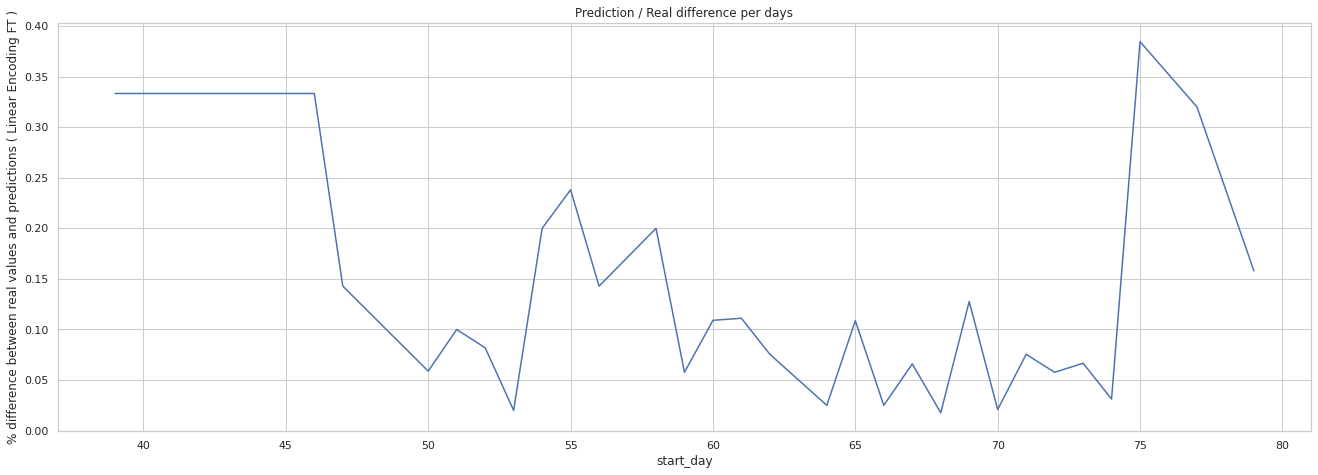

In [101]:
test_copy = df.loc[(df.dataset == "test") & (df.duration.notnull())].copy()
test_copy["preds"] = linear_tuned_test_preds['output'].ravel()
test_copy["daily_preds_sum"] = test_copy.groupby("start_day")["preds"].transform("sum").astype(int)
test_copy["daily_real_sum"] = test_copy.groupby("start_day")["duration"].transform("sum")
temp = test_copy.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions ( Linear Encoding FT )")

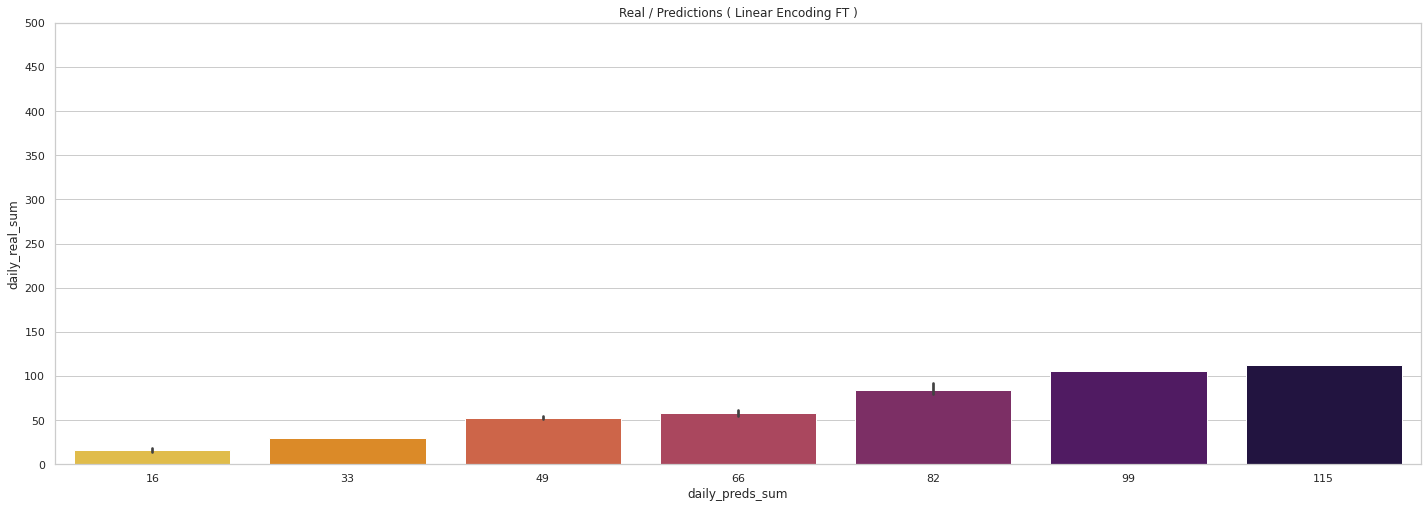

In [102]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20], palette = "inferno_r")
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions ( Linear Encoding FT )")
plt.show()

Text(0.5, 1.0, 'Daily differences between real values and predictions ( Linear Encoding FT )')

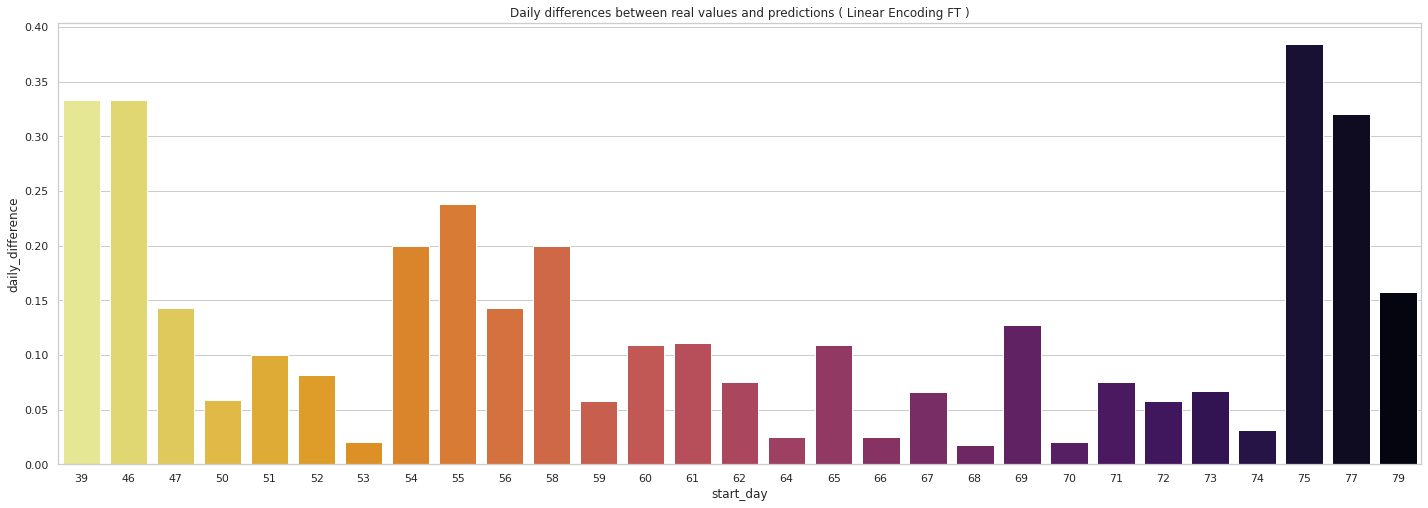

In [103]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions ( Linear Encoding FT )")

### Our results were like this :

In [104]:
before_optimization = pd.DataFrame({"r2" : [linear_r2, periodic_r2, lgb_r2],
              "mae" : [linear_mae, period_mae, lgb_mae],
              "rmse" : [linear_rms, periodic_rms, lgb_rmse]}, index = ["Transformer - Linear Encoding", "Transformer - Periodic Encoding",
                     "LightGBM"]) # parameter needs more iterations
before_optimization

,r2,mae,rmse
Transformer - Linear Encoding,-0.001241,2.349386,3.039014
Transformer - Periodic Encoding,-0.001241,2.347504,3.044111
LightGBM,0.653998,0.747642,1.786500


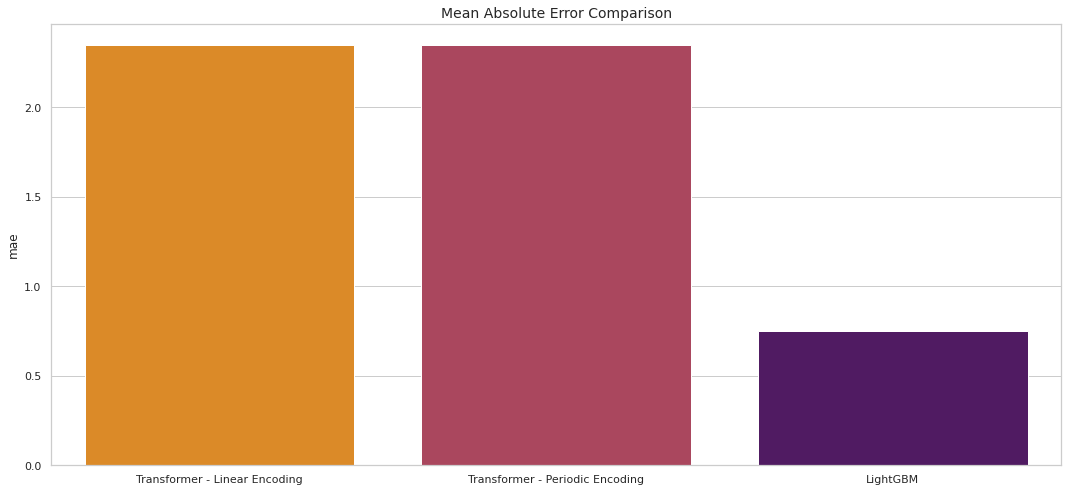

In [105]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.mae,palette = "inferno_r")
plt.title("Mean Absolute Error Comparison", fontsize = 14)
plt.tight_layout()


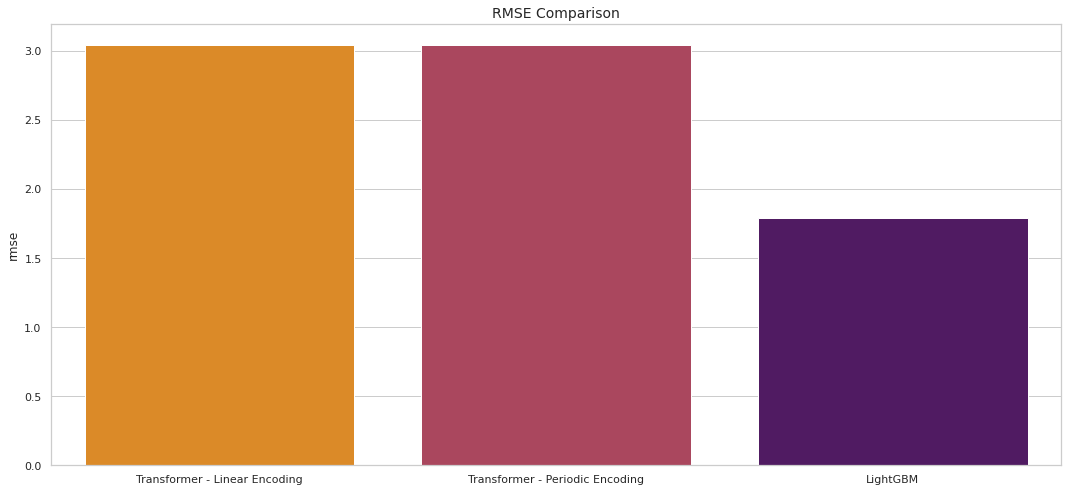

In [106]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.rmse,palette = "inferno_r")
plt.title("RMSE Comparison", fontsize = 14)
plt.tight_layout()


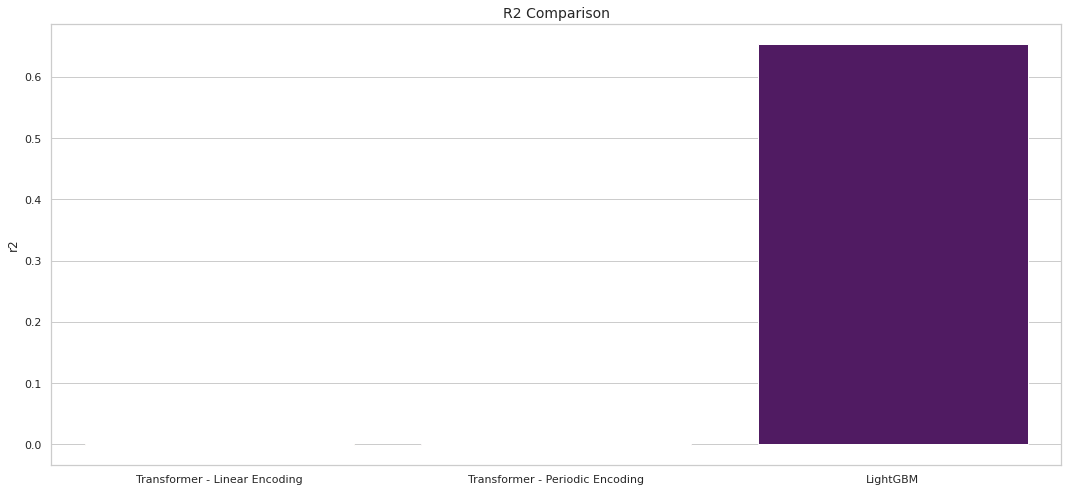

In [107]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.r2,palette = "inferno_r")
plt.title("R2 Comparison", fontsize = 14)
plt.tight_layout()


### After optimization:

In [108]:
after_optimization = pd.DataFrame({"r2" : [linear_tuned_r2, periodic_tuned_r2, lgb_tuned_r2],
              "mae" : [linear_tuned_mae, periodic_tuned_mae, lgb_tuned_mae],
              "rmse" : [linear_tuned_rms, periodic_tuned_rms, lgb_tuned_rmse]}, index = ["Transformer - Linear Encoding TUNED", "Transformer - Periodic Encoding TUNED",
                     "LightGBM TUNED"]) # parameter needs more iterations
after_optimization

,r2,mae,rmse
Transformer - Linear Encoding TUNED,-0.002697,2.350571,3.041224
Transformer - Periodic Encoding TUNED,-0.005942,2.345713,3.046141
LightGBM TUNED,0.668920,0.934894,1.747552


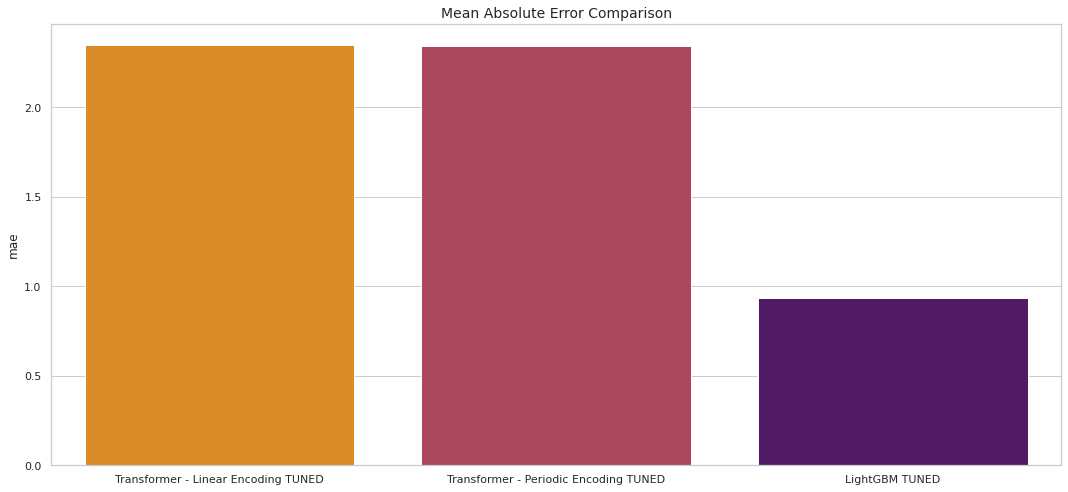

In [109]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.mae,palette = "inferno_r")
plt.title("Mean Absolute Error Comparison", fontsize = 14)
plt.tight_layout()


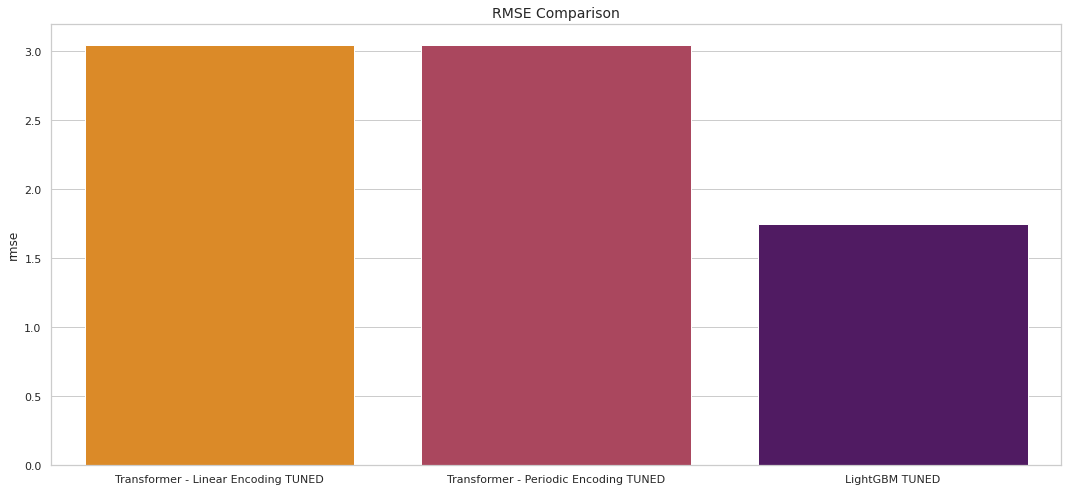

In [110]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.rmse,palette = "inferno_r")
plt.title("RMSE Comparison", fontsize = 14)
plt.tight_layout()


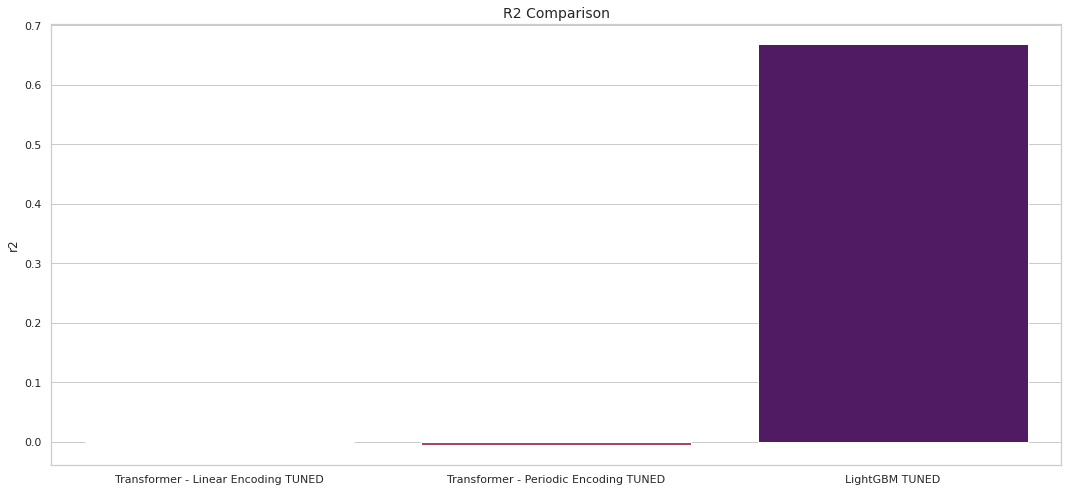

In [111]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.r2,palette = "inferno_r")
plt.title("R2 Comparison", fontsize = 14)
plt.tight_layout()
